In [1]:
# %load ../startup.py
import os,sys
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

os.environ['PYTHONPATH']=os.environ.get('LIB')
if not os.environ.get('LIB') in sys.path: 
    sys.path.insert(0,os.environ.get('LIB'))

DAT_DIR = os.environ.get('DAT_DIR')    
FIG_DIR = os.environ.get('FIG_DIR')
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline
%load_ext rpy2.ipython

import matplotlib.text as text
import pandas as pd
import numpy as np
import pylab as pl
import scipy as sp
import sys
import rpy2 
import os 
from matplotlib import gridspec
from scipy.interpolate import splev, splrep
import xlwt
import seaborn as sns
from scipy import stats
import rpy2.robjects.packages as rpackages
import seaborn as sns
from statsmodels import robust


from heprnhci.db.mongo import *


from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important;}</style>")) # increase jupyter screen width to 100%
pd.options.display.max_colwidth = 500
pd.set_option('display.precision',2)

HCI=openMongo(db=os.environ.get('MONGO_HCIDB'),host=os.environ.get('MONGO_HOST'),auth=False)


Populating the interactive namespace from numpy and matplotlib


/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [2]:
FIG_DIR

'/home/ishah/ipynb/heprn-hci-nam/outputs/figs/v2.2/'

# Goal

Summary of results for the entire analysis and create figures to be included in the MS

In [42]:
C1 = [u'LM',u'ES',u'St',u'MF',u'DT',  u'NS', u'Ap', u'CN']

# Functions
from sklearn.metrics import r2_score

def mycorr(x, y, **kws):
    nna = x.notna() & y.notna()
    r,p= sp.stats.pearsonr(x[nna], y[nna])
    return r
    
def corrfunc(x, y, **kws):
    nna = x.notna() & y.notna()
    r,p = sp.stats.pearsonr(x[nna], y[nna])
    ax = plt.gca()
    ax.annotate(r"$\rho$={:.2f}".format(r)+r"({:.2f})".format(p),
                xy=(.1, .9), size=8,
                xycoords=ax.transAxes)

def mr2_score(x,y, **kws):
    nna = x.notna() & y.notna()
    r = r2_score(np.log10(x[nna]), np.log10(y[nna]))
    ax = plt.gca()
    ax.annotate(r"$R^2$={:.2f}".format(r),
                xy=(.1, .8), size=8,
                xycoords=ax.transAxes)
    
    
def overunder(x,y, yname='',xname='',**kwds):
    nna  = x.notna() & y.notna()
    ygtx = np.sum(y[nna]>x[nna])
    xgty = np.sum(x[nna]>y[nna])
    ax = plt.gca()
    ax.annotate(r"%s>:%i %s>:%i" % (xname,xgty,yname,ygtx),
                xy=(.2, .03), size=8,
                xycoords=ax.transAxes)

# IVV= ['loael_p05','loael_p50','loael_p95']
# IVT= ['aed_p05','aed_p50','aed_p95']
# DM = ['auc','cmax','auc']

# y = POD_tox
# x = POD_name

def calc_SSTotal(x,**kws):        
    return ((x-x.mean())**2).sum()

def calc_Resid(x,y,**kws):
    return ((y-x)**2).sum()

def calc_RMSE(x,y,**kws):
    return np.sqrt(calc_Resid(x,y))

def calc_R2(x,y,log_trans=False,**kws):    
    r2 = 1-(calc_Resid(x,y)/calc_SSTotal(x))
    if log_trans:
        r2 = 10**r2
    return r2


def calc_pearson(x,y,**kws):
    return sp.stats.pearsonr(x,y)[0]

def calc_spearman(x,y,**kws):
    return sp.stats.spearmanr(x,y)[0]

def calc_spearman_p(x,y,**kws):
    return sp.stats.spearmanr(x,y)[1]

def calc_pearson_p(x,y,**kws):
    return sp.stats.pearsonr(x,y)[1]

def calc_MeanFold_yx(x,y,log_trans=False,**kws):
    """Mean(y/x)"""
    fc= np.mean(y-x)    
    if log_trans:
        fc = 10**fc
    return fc

def calc_LPR(x,y,**kws):
    """mean(y-x)"""
    return np.mean(y-x)

def calc_MeanFold_xy(x,y,log_trans=False,**kws):
    fc= np.mean(x-y)    
    if log_trans:
        fc = 10**fc
    return fc    

def calc_Overpred(x,y,**kws):
    """Fraction """
    return  1.0*np.sum(y<x)/len(x)

def calc_Underpred(x,y,**kws):
    return  1.0*np.sum(y>x)/len(x)

def calc_WithinLog10(x,y,**kws):
    return  1.0*np.sum(np.abs(x-y)<=1)/len(x)

def calc_BeyondLog10(x,y,**kws):
    return  1.0*np.sum(np.abs(x-y)>1)/len(x)

def calc_n(x,y,**kws):
    return len(x)

def calc_Underpred_MeanFold_xy(x,y,**kws):
    return calc_MeanFold_xy(x[x<y],y[x<y],**kws)

def calc_Overpred_MeanFold_yx(x,y,**kws):
    return calc_MeanFold_yx(x[x>y],y[x>y],**kws)

    
Summary_F = dict(RMSE=calc_RMSE,
                 R2=calc_R2,
                 resid=calc_Resid,
                 R_p=calc_pearson,
                 R_s=calc_spearman,
                 p_s=calc_spearman_p,
                 p_p=calc_pearson_p,
                 PR=calc_MeanFold_yx,
                 LPR = calc_LPR,
                 n_chem=calc_n,
                 LPR_lt_1=calc_WithinLog10,
                 LPR_gt_l=calc_BeyondLog10,
                 Underpred=calc_Underpred,
                 Overpred=calc_Overpred,
                 Underpred_PR=calc_Underpred_MeanFold_xy,
                 Overpred_PR=calc_Overpred_MeanFold_yx
                 )

def _p05(X):  return np.percentile(X,5)
def _p95(X): return np.percentile(X,95)
def _p50(X): return np.percentile(X,50)
def _n(X): return len(X)



# HepRn Effects

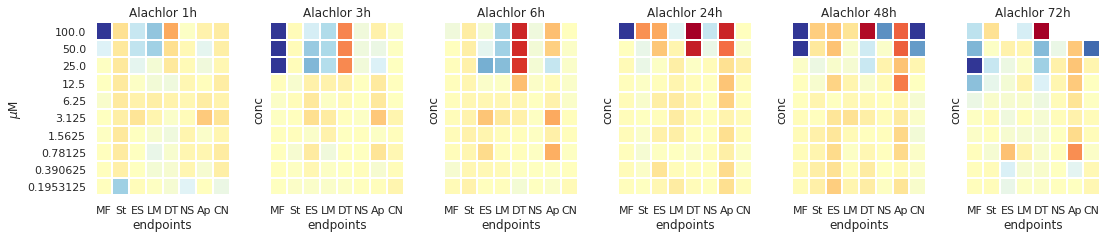

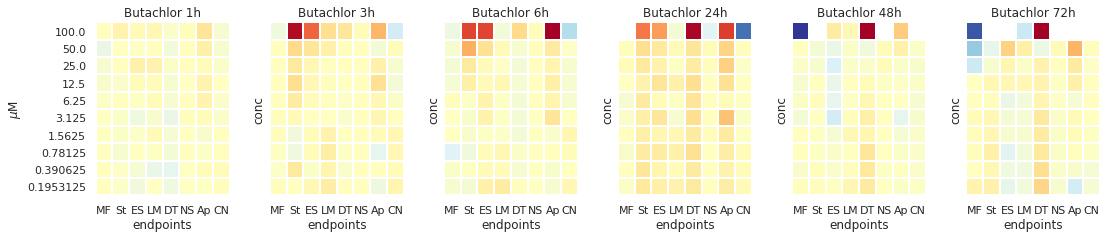

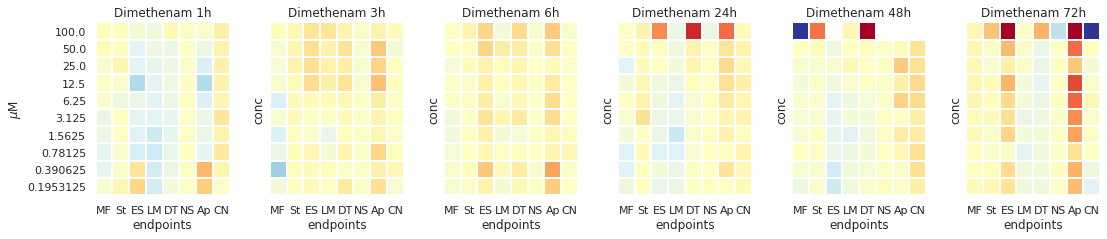

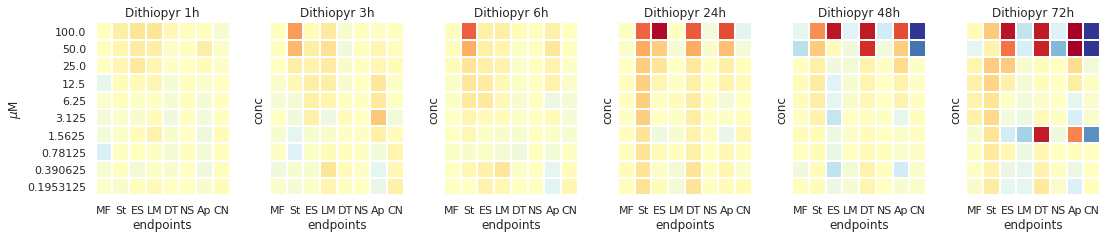

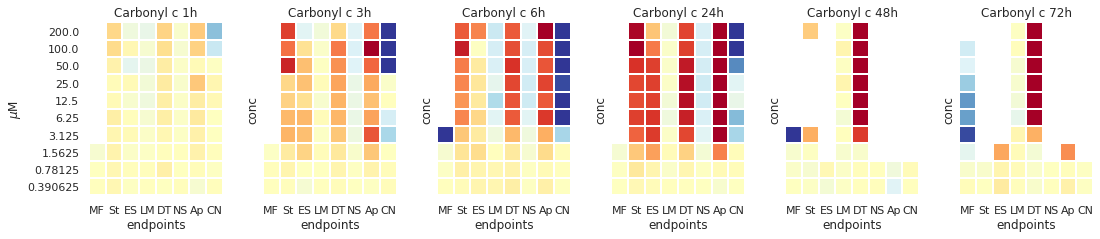

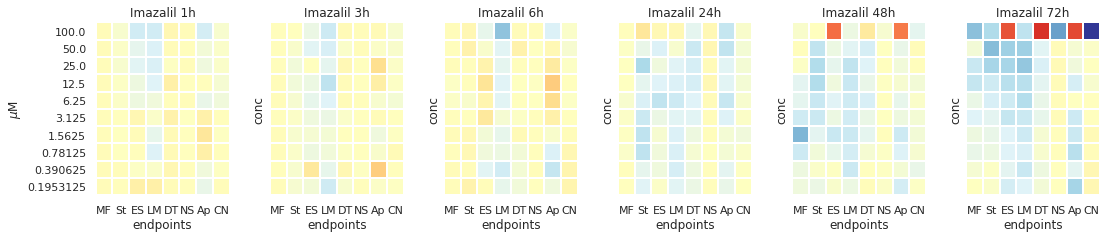

In [6]:
from hci.fc import *
sns.set(style='white')
chem='Butachlor'
va ='l2fc_ctrl'
ft  ='FA1'

for chem in ['Alachlor','Butachlor','Dimethenamid','Dithiopyr','Carbonyl cyanide chlorophenylhydrazone',
             'Imazalil']:
    fig = vizChemCR(chem,feat=ft,val=va,pv=None,dbc_fc=HCI.heprn_ch,dbc_ft=HCI.hci_feats)
    fig.savefig(FIG_DIR+'heprn-fc-%s.svg' % chem.lower().replace(' ','-'))
    fig.savefig(FIG_DIR+'heprn-fc-%s.png' % chem.lower().replace(' ','-'),dpi=300)

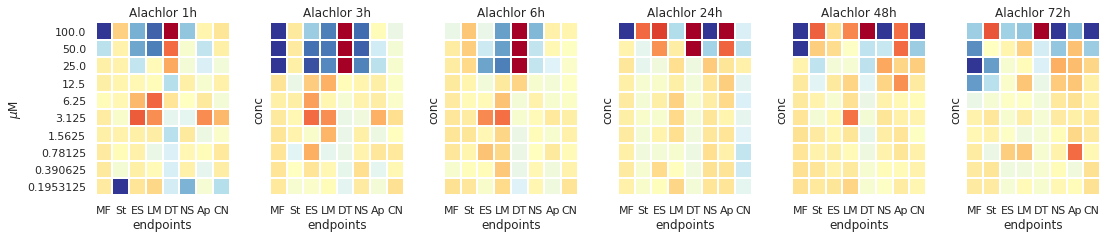

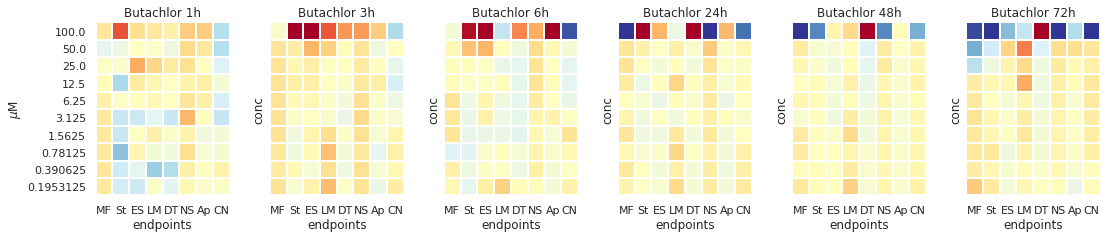

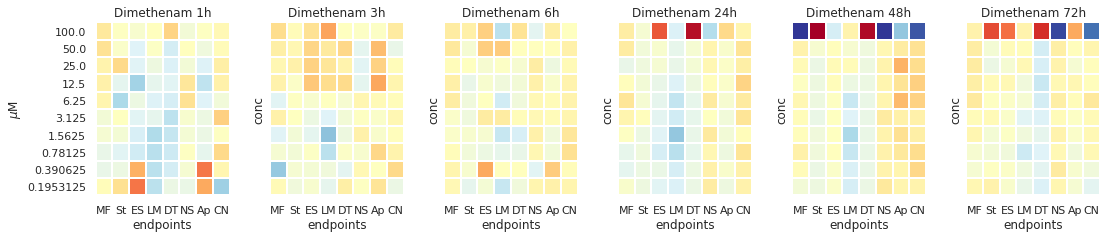

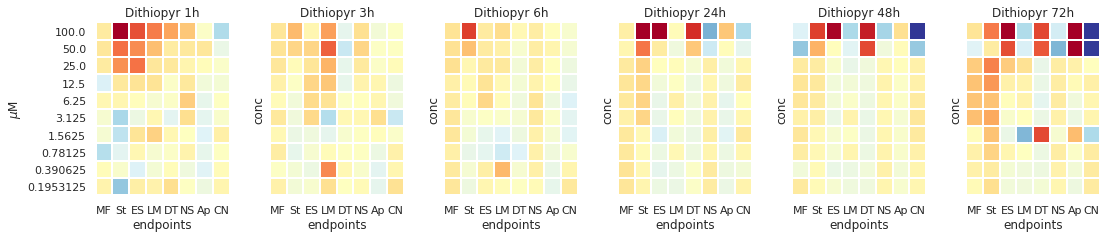

In [7]:
from hci.fc import *
sns.set(style='white')
chem='Butachlor'
va ='z_plt'
ft  ='FA1'

for chem in ['Alachlor','Butachlor','Dimethenamid','Dithiopyr']:
    fig = vizChemCR(chem,feat=ft,val=va,pv=None,vm=3,dbc_fc=HCI.heprn_ch,dbc_ft=HCI.hci_feats)
    fig.savefig(FIG_DIR+'heprn-z-%s.svg' % chem.lower().replace(' ','-'))
    fig.savefig(FIG_DIR+'heprn-z-%s.png' % chem.lower().replace(' ','-'),dpi=300)

## Summary for all chmicals

In [5]:
FT = pd.DataFrame(HCI.hci_feats.find({},dict(_id=0)))
{i.FA1:i.FN1 for k,i in FT.iterrows()}
FT = {'DT': 'DNA Texture',
 'MF': 'Mitochond. Func.',
 'LM': 'Lysosomal Mass',
 'NS': 'Nuclear Size',
 'CN': 'Cell Number',
 'ES': 'ER Stress',
 'Ap': 'Apoptosis',
 'St': 'Steatosis'}

In [9]:
from hci.fc import *
import seaborn as sns 
sns.set(style='white')

C0 = ['MF','St','ES','LM','DT','NS','Ap','CN']
C1 = ['%s_%ih' % (ft,t) for t in [24,48,72] for ft in C0 ]


CH0 = HCI.potency.find(dict(assay='HepRn')).distinct('name') +\
      HCI.chemicals.find(dict(stype='ctrl+')).distinct('chem_name')
X0 = pd.concat([getChemFC(chem,dbc_fc=HCI.heprn_ch,dbc_ft=HCI.hci_feats) for chem in CH0])

In [10]:
X0.insert(0,'ft_name',X0.FA1.replace(FT))
X0.insert(0,'ft_name_h',X0.ft_name+X0.timeh.apply(lambda i: " %ih" % i))

In [11]:

C1 = ['%s %ih' % (ft,t) for t in [24,48,72] for ft in [FT[k] for k in C0] ]

X1 = X0.copy()
#X1 = X1[(X1.timeh.isin([24,48,72])) & (X1.conc>25) & (X1.conc<=50)]
X1 = X1[(X1.timeh.isin([24,48,72])) & (X1.conc>=90)]
FC0 = X1.pivot_table(index=['name'],columns='ft_name_h',values='l2fc_plt',aggfunc=np.mean)[C1]\
        .replace([-np.inf,np.inf],0)
Z0  = X1.pivot_table(index=['name'],columns='ft_name_h',values='z_plt',aggfunc=np.mean)[C1]\
        .replace([-np.inf,np.inf],0)

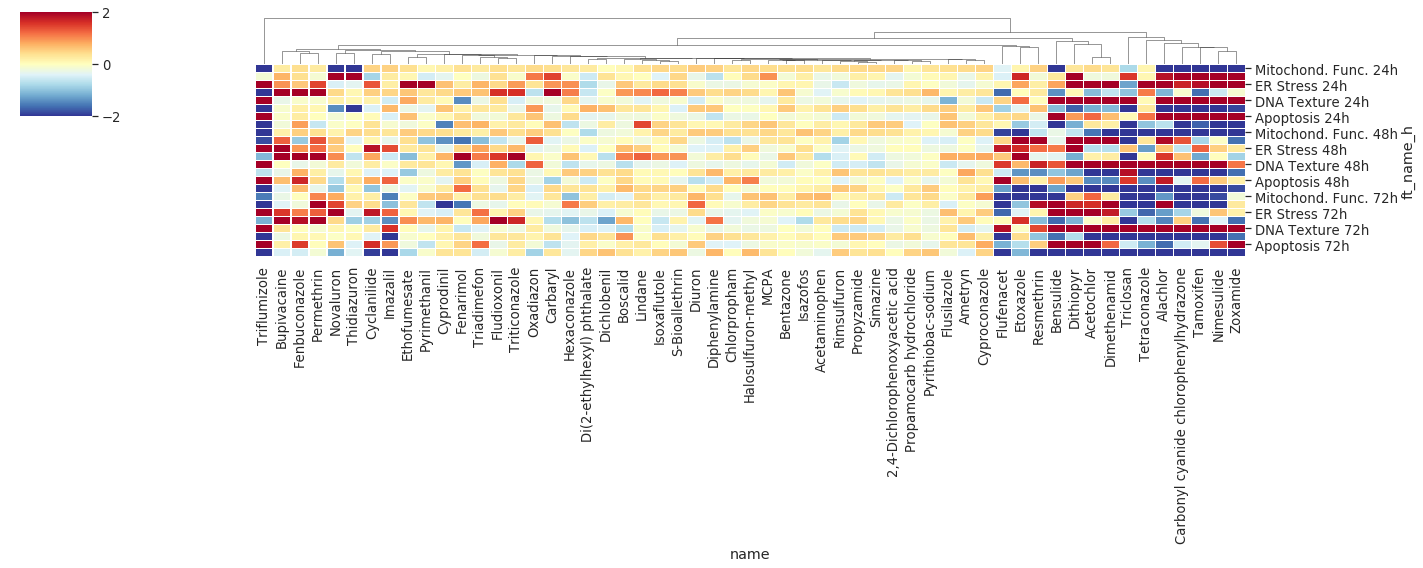

In [12]:
sns.set(style='white',font_scale=1.2)
g = sns.clustermap(Z0.T,col_cluster=True,row_cluster=False,metric='euclidean',vmin=-2,vmax=2,
                   linewidths=0.2,cmap=cm.RdYlBu_r,figsize=(20,8))
g.savefig(FIG_DIR+'heprn-z-plt-effects-max.svg')
g.savefig(FIG_DIR+'heprn-z-plt-effects-max.png',dpi=300)

In [13]:
C1 = ['%s %ih' % (ft,t) for t in [24,48,72] for ft in [FT[k] for k in C0] ]

X1 = X0.copy()

In [20]:
C1

['Mitochond. Func. 24h',
 'Steatosis 24h',
 'ER Stress 24h',
 'Lysosomal Mass 24h',
 'DNA Texture 24h',
 'Nuclear Size 24h',
 'Apoptosis 24h',
 'Cell Number 24h',
 'Mitochond. Func. 48h',
 'Steatosis 48h',
 'ER Stress 48h',
 'Lysosomal Mass 48h',
 'DNA Texture 48h',
 'Nuclear Size 48h',
 'Apoptosis 48h',
 'Cell Number 48h',
 'Mitochond. Func. 72h',
 'Steatosis 72h',
 'ER Stress 72h',
 'Lysosomal Mass 72h',
 'DNA Texture 72h',
 'Nuclear Size 72h',
 'Apoptosis 72h',
 'Cell Number 72h']

In [14]:
X1.conc.value_counts()

12.50      4140
100.00     4140
1.56       4140
6.25       4140
3.12       4140
25.00      4140
50.00      4140
0.78       3780
0.39       3780
0.20       3060
200.00     1080
7.81        360
15.62       360
3.91        360
1.95        360
62.50       360
125.00      360
250.00      360
800.00      360
500.00      360
1000.00     360
400.00      360
31.25       360
Name: conc, dtype: int64

In [15]:
#X1 = X1[(X1.timeh.isin([24,48,72])) & (X1.conc>25) & (X1.conc<=50)]
X1 = X1[(X1.timeh.isin([24,48,72])) & (X1.conc<=1)]
FC0 = X1.pivot_table(index=['name'],columns='ft_name_h',values='l2fc_plt',aggfunc=np.mean)[C1]\
        .replace([-np.inf,np.inf],0)
Z0  = X1.pivot_table(index=['name'],columns='ft_name_h',values='z_plt',aggfunc=np.mean)[C1]\
        .replace([-np.inf,np.inf],0)

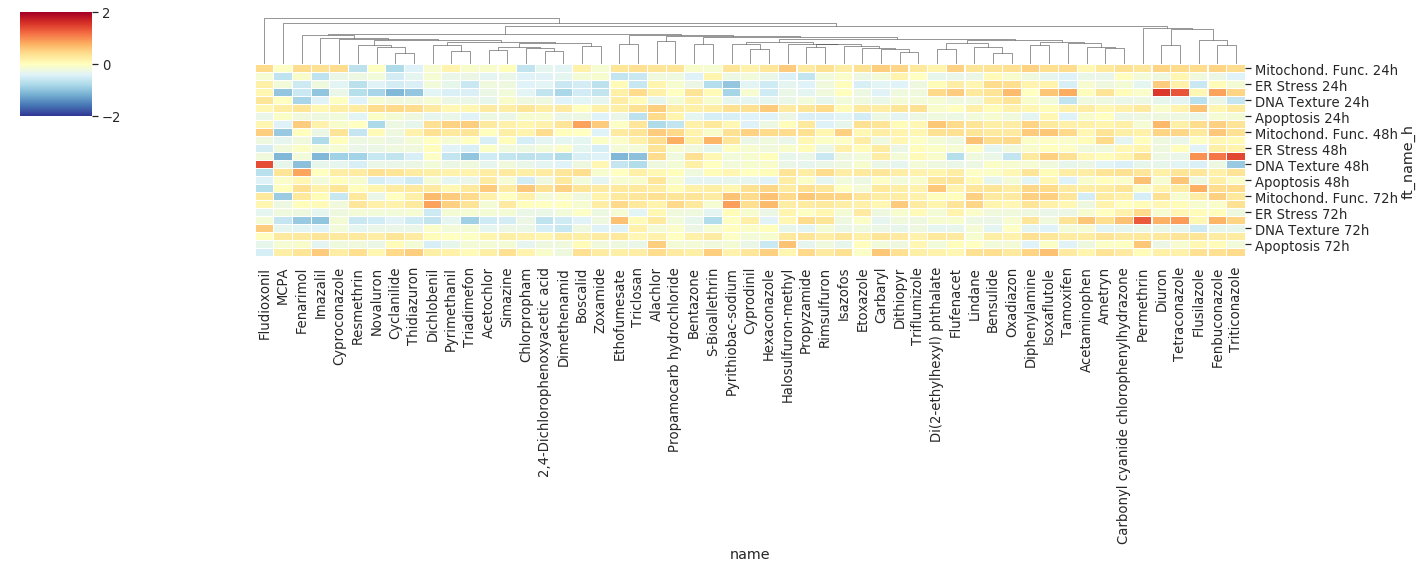

In [16]:
sns.set(style='white',font_scale=1.2)
g = sns.clustermap(Z0.T,col_cluster=True,row_cluster=False,metric='euclidean',vmin=-2,vmax=2,
                   linewidths=0.2,cmap=cm.RdYlBu_r,figsize=(20,8))
g.savefig(FIG_DIR+'heprn-z-plt-effects-lt1.svg')
g.savefig(FIG_DIR+'heprn-z-plt-effects-lt1.png',dpi=300)

In [571]:
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler
# import seaborn as sns

# fig = pl.figure(figsize=(10,10))
# ax = pl.subplot(1,1,1)

# tsne = TSNE(n_components=2,verbose=1,random_state=0,perplexity=5,learning_rate=20,
#             n_iter=2000)

# X2 = X0.copy()
# X2 = X2[(X2.timeh.isin([24,48,72]))]
# #X1 = X1[(X1.timeh.isin([24,48,72])) & (X1.conc<=50)]
# FC2 = X1.pivot_table(index=['name','timeh','conc','stype'],
#                      columns='FA1',values='l2fc_plt',aggfunc=np.mean)\
#         .replace([-np.inf,np.inf],0) 
# Z2  = X1.pivot_table(index=['name','timeh','conc','stype'],
#                      columns='FA1',values='z_plt',aggfunc=np.mean)\
#         .replace([-np.inf,np.inf],0)       
# Z3  = Z2.copy()
# Z3[Z3.abs()<=1]=0
# Z3[Z3<=-1]=-1
# Z3[Z3>1]=1

# XY=tsne.fit_transform(Z3)
# X_loc1 = Z2.index.to_frame()
# X_loc1.insert(X_loc1.shape[1],'x',XY[:,0])
# X_loc1.insert(X_loc1.shape[1],'y',XY[:,1])
# X_loc1 = X_loc1.reset_index(drop=True)
# #X_loc['timeh']=X_loc.timeh.astype(np.uint0)

# g = sns.scatterplot(x='x',y='y',data=X_loc1,ax=ax,hue='timeh',palette='rainbow',
#                 x_jitter=5,y_jitter=5,legend=False)

# Hits

## Summarize hits

In [4]:
X = pd.DataFrame(HCI.potency.find(dict(assay='HepRn',platform='APR:HepRn:Tm:Ft',
                                       potency_name='ac50_p05',
                                       potency_meth='tcpl:ac50:manual_qc'),
                                  dict(_id=0)))
X1 = X.pivot_table(index=['name','timeh'],
                   columns='ft',
                   values='potency_val')

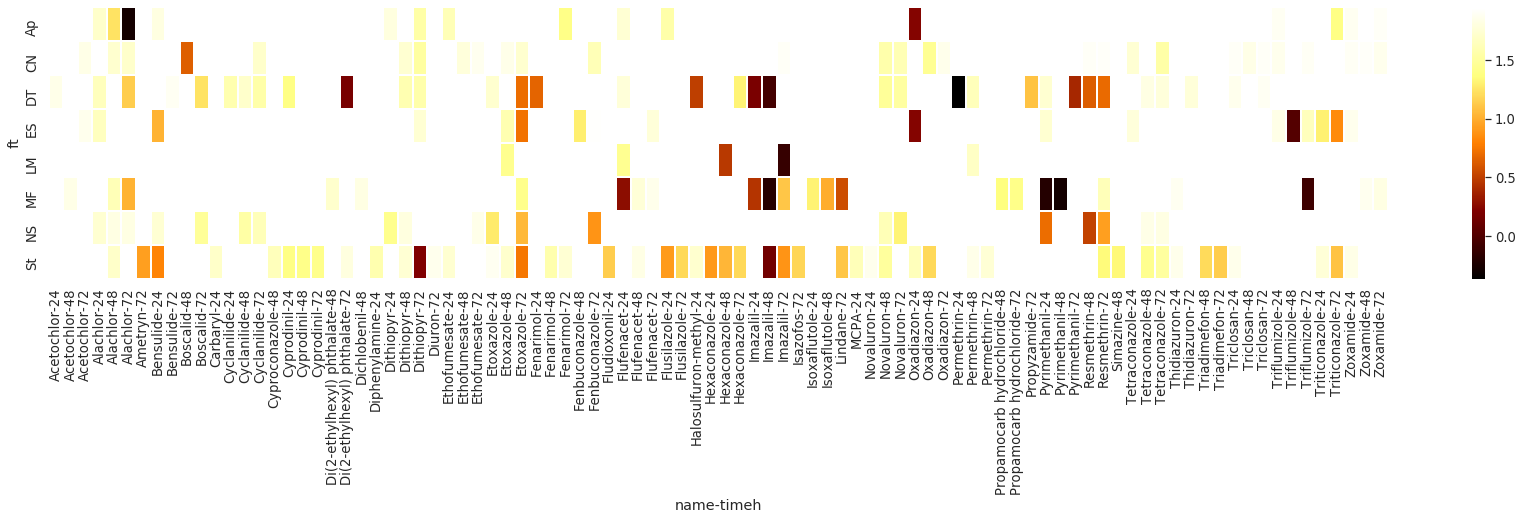

In [18]:
pl.figure(figsize=(30,5))
ax=pl.subplot(1,1,1)
X2 = np.log10(X1.T)
sns.heatmap(X2,linewidth=1,cmap=cm.afmhot,ax=ax)

## Figure 2: Distribution of hits

In [64]:
# Data
C0 = ['MF','St','ES','LM','DT','NS','Ap','CN']
X = pd.DataFrame(HCI.potency.find(dict(assay='HepRn',platform='APR:HepRn:Tm:Ft',
                                       potency_name='ac50_p05',
                                       potency_meth='tcpl:ac50:manual_qc'),
                                  dict(_id=0)))\
       .rename(columns=dict(timeh='Time [h]'))
N_hits = X.pivot_table(index=['Time [h]'],columns='ft',values='potency_val',aggfunc=len,fill_value=0)[C0]

In [65]:
N_hits.rename(columns=FT,inplace=True)

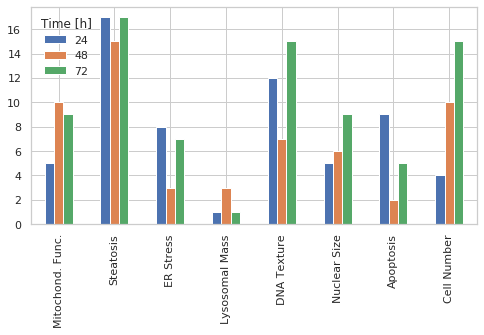

In [66]:
# Draw
fig = pl.figure(figsize=(8,4))
ax = pl.subplot(1,1,1)
N_hits.T.plot.bar(ax=ax)
ax.set_xlabel('')
fig.savefig(FIG_DIR+'figure-2.png',dpi=600)
fig.savefig(FIG_DIR+'figure-2.svg',dpi=600,bbox_inches='tight')


In [11]:
X.head()

,ft,platform,assay,dsstox_sid,name,time [h],potency_name,potency_val,days_ivt,potency_meth
0,St,APR:HepRn:Tm:Ft,HepRn,DTXSID0020446,Diuron,72,ac50_p05,72.73,3.0,tcpl:ac50:manual_qc
1,St,APR:HepRn:Tm:Ft,HepRn,DTXSID0032601,Cyproconazole,48,ac50_p05,43.80,2.0,tcpl:ac50:manual_qc
2,DT,APR:HepRn:Tm:Ft,HepRn,DTXSID0032651,Thidiazuron,72,ac50_p05,59.45,3.0,tcpl:ac50:manual_qc
3,MF,APR:HepRn:Tm:Ft,HepRn,DTXSID0032651,Thidiazuron,24,ac50_p05,76.90,1.0,tcpl:ac50:manual_qc
4,St,APR:HepRn:Tm:Ft,HepRn,DTXSID0032651,Thidiazuron,24,ac50_p05,72.04,1.0,tcpl:ac50:manual_qc


## Figure 3: Distribution of potency values

In [ ]:
import seaborn as sns

sns.set(style='ticks',font_scale=1.0)

g = sns.catplot(x='potency_val',y='Time [h]',data=X.replace(dict(ft=FT)),
                col='ft',col_order=[FT[i] for i in C0],
                col_wrap=4,
                height=3,kind='box',orient='h',
                linewidth=0.5,width=0.8)
g.set(xticks=[0,5,10,25,50,75])
g.set_titles(row_template='{row_name}',col_template='{col_name}')
g.set(xscale='log',xlabel=r'AC50 [$\mu$M]',ylabel='Time [h]')
pl.subplots_adjust(wspace=0.3,hspace=0.5,top=0.8,bottom=0.1)
g.savefig(FIG_DIR+'figure-3.png',dpi=600)
g.savefig(FIG_DIR+'figure-3.svg',dpi=500)

## S4: HepRn AC50

In [22]:
X = pd.DataFrame(HCI.potency.find(dict(assay='HepRn',platform='APR:HepRn:Tm:Ft',
                                       potency_name='ac50_p05',
                                       potency_meth='tcpl:ac50:manual_qc'),
                                  dict(_id=0)))

X1 = X.pivot_table(index=['dsstox_sid','name','timeh'],
                      columns='ft',
                      values='potency_val')

X2 = X.groupby(['dsstox_sid','name','timeh'])\
            .aggregate(dict(potency_val=[_p05,_p50,_p95]))
X2.columns=[i.replace('potency_val','heprn_AC50')+j for i,j in X2.columns]

SuppTab2 = X1.merge(X2,left_index=True,right_index=True)

SuppTab2.to_excel(SUP_DIR+'S4-heprn-hci-ac50.xlsx')

# Compare potency w/wo QC

## HepRn

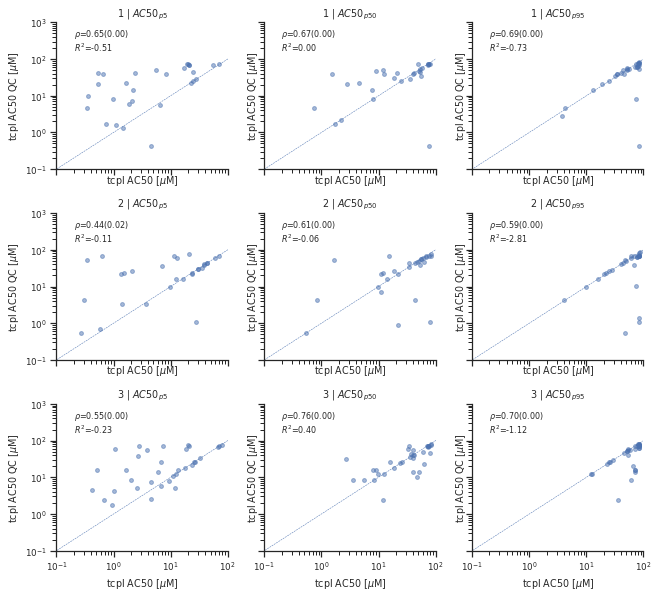

In [56]:
# Data
HepRnTm = pd.DataFrame(HCI.potency.find(dict(assay='HepRn',platform='APR:HepRn:Tm'),
                                        dict(_id=0)))

X = HepRnTm.pivot_table(index=['dsstox_sid','name','potency_name','timeh','days_ivt'],
                        columns='potency_meth',
                        values='potency_val'
                       ).reset_index()\
                 .replace(dict(potency_name=dict(ac50_p05=r'$AC50_{p5}$',
                                                  ac50_p50=r'$AC50_{p50}$',
                                                  ac50_p95=r'$AC50_{p95}$')))

# Draw
sns.set(font_scale=0.8,style='ticks')

g=sns.FacetGrid(X,
                row='days_ivt',col='potency_name',
                row_order=[1,2,3],
                height=2.8,aspect=1.1,
                legend_out=True)
A,B = 'tcpl:ac50','tcpl:ac50:manual_qc'
g.map(pl.scatter,A,B,s=15,alpha=0.5)
g.map(corrfunc,A,B)
g.map(mr2_score,A,B)
g.map_dataframe(pl.plot,[0,1e3],[0,1e3],'--',linewidth=0.5)#,linestyle='--')#,linewidth=0.5,color='grey')
g.set_titles(row_template='{row_name}',col_template='{col_name}')
g.set(xscale='log',yscale='log',xlim=[1e-1,1e2],ylim=[1e-1,1e3])
g.set(xlabel=r'tcpl AC50 [$\mu$M]',
      ylabel=r'tcpl AC50 QC [$\mu$M]')

g.fig.tight_layout()

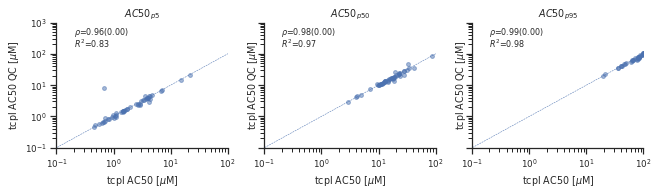

In [58]:
# Data
ToxCast = pd.DataFrame(HCI.potency.find(dict(assay='ToxCast',platform='All'),
                                        dict(_id=0)))

X = ToxCast.pivot_table(index=['dsstox_sid','name','potency_name','timeh','days_ivt'],
                        columns='potency_meth',
                        values='potency_val'
                       ).reset_index()\
                 .replace(dict(potency_name=dict(ac50_p05=r'$AC50_{p5}$',
                                                  ac50_p50=r'$AC50_{p50}$',
                                                  ac50_p95=r'$AC50_{p95}$')))

# Draw
sns.set(font_scale=0.8,style='ticks')

g=sns.FacetGrid(X,col='potency_name',
                #row_order=[1,2,3],
                height=2.8,aspect=1.1,
                legend_out=True)
A,B = 'tcpl:ac50','tcpl:ac50:manual_qc'
g.map(pl.scatter,A,B,s=15,alpha=0.5)
g.map(corrfunc,A,B)
g.map(mr2_score,A,B)
g.map_dataframe(pl.plot,[0,1e3],[0,1e3],'--',linewidth=0.5)#,linestyle='--')#,linewidth=0.5,color='grey')
g.set_titles(row_template='{row_name}',col_template='{col_name}')
g.set(xscale='log',yscale='log',xlim=[1e-1,1e2],ylim=[1e-1,1e3])
g.set(xlabel=r'tcpl AC50 [$\mu$M]',
      ylabel=r'tcpl AC50 QC [$\mu$M]')

g.fig.tight_layout()

# Compare ToxCast and HepRn

In [62]:
# Data
HepRnTm = pd.DataFrame(HCI.potency.find(dict(assay='HepRn',platform='APR:HepRn:Tm'),dict(_id=0)))
ToxCast = pd.DataFrame(HCI.potency.find(dict(assay='ToxCast',platform='All'),dict(_id=0)))

HepRnTx = HepRnTm.merge(ToxCast,on=['dsstox_sid','name','potency_name','potency_meth','ft'],how='left')\
                 .replace(dict(potency_name=dict(ac50_p05=r'$AC50_{p5}$',
                                                  ac50_p50=r'$AC50_{p50}$',
                                                  ac50_p95=r'$AC50_{p95}$')))


HepRnTm = pd.DataFrame(HCI.potency.find(dict(assay='HepRn',platform='APR:HepRn:Tm'),dict(_id=0)))
TxTech  = pd.DataFrame(HCI.potency.find(dict(assay='ToxCast',platform={'$ne':'All'}),dict(_id=0)))

HepRnTxTch = HepRnTm.merge(TxTech,on=['dsstox_sid','name','potency_name','potency_meth','ft'],how='left')\
                 .replace(dict(potency_name=dict(ac50_p05=r'$AC50_{p5}$',
                                                  ac50_p50=r'$AC50_{p50}$',
                                                  ac50_p95=r'$AC50_{p95}$')))
RES=[]
Ci = ['potency_name','timeh_x','platform_y']
for Fi,Xi in HepRnTxTch[HepRnTxTch.potency_meth=='tcpl:ac50:manual_qc'].groupby(Ci):
    R = dict(zip(Ci,Fi))
    R.update({k:f(Xi['potency_val_x'],Xi['potency_val_y']) for k,f in Summary_F.items()})
    RES.append(R)

HepRnTxTch_cmp = pd.DataFrame(RES)

In [70]:
HepRnTxTch_cmp.head().T

,0,1,2,3,4
potency_name,$AC50_{p50}$,$AC50_{p50}$,$AC50_{p50}$,$AC50_{p50}$,$AC50_{p50}$
timeh_x,24,24,24,24,24
platform_y,ACEA,APR,ATG,BSK,CEETOX
RMSE,1.8e+02,3e+02,1.9e+02,1.9e+02,1.2e+02
R2,-1,-4.9,-1.2,-1.1,-1.3
resid,3.2e+04,8.8e+04,3.6e+04,3.4e+04,1.4e+04
R_p,-0.42,-0.32,-0.16,0.17,0.056
R_s,-0.49,-0.31,-0.2,0.13,-0.048
p_s,0.012,0.12,0.3,0.5,0.91
PR,-6.3,39,-17,-26,-30


## Assay correlations: Figure 4

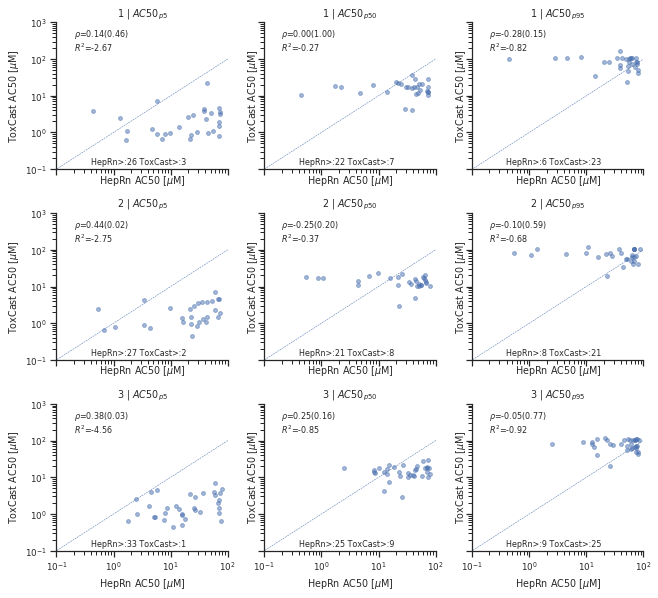

In [34]:
sns.set(font_scale=0.8,style='ticks')

g=sns.FacetGrid(HepRnTx[HepRnTx.potency_meth=='tcpl:ac50:manual_qc'],
                row='days_ivt_x',col='potency_name',#hue='potency_meth',
                row_order=[1,2,3],
                height=2.8,aspect=1.1,
                legend_out=True)
A,B = 'potency_val_x','potency_val_y'
g.map(pl.scatter,A,B,s=15,alpha=0.5)
g.map(corrfunc,A,B)
g.map(mr2_score,A,B)
g.map(overunder,A,B,xname='HepRn',yname='ToxCast')
#D = ['0.01','0.1','1','10','100','1000','10000']
#D = ['0.1','1','100','100','1000']
g.map_dataframe(pl.plot,[0,1e3],[0,1e3],'--',linewidth=0.5)#,linestyle='--')#,linewidth=0.5,color='grey')
g.set_titles(row_template='{row_name}',col_template='{col_name}')
g.set(xscale='log',yscale='log',xlim=[1e-1,1e2],ylim=[1e-1,1e3])
g.set(xlabel=r'HepRn AC50 [$\mu$M]',
      ylabel=r'ToxCast AC50 [$\mu$M]')

g.fig.tight_layout()
g.savefig(FIG_DIR+'figure-4-tx-vs-heprn-ac50-cmp.png')
g.savefig(FIG_DIR+'figure-4-tx-vs-heprn-ac50-cmp.svg')

## Figure 5. Assay correlations by platform

In [1]:
# Old
# sns.set(font_scale=1.0,style='whitegrid')

# g = sns.lmplot(x='n_chem',y='R_p',col='platform_y',col_wrap=3,
#                data=HepRnTxTch_cmp.rename(columns=dict(potency_name='Potency')), 
#                hue='Potency',fit_reg=False,
#                scatter_kws={"s": 30},
#                height=2.5
#               )
# g.set(xlabel=r'$n$ ',
#       ylabel=r'$\rho_p$',
#      )
# g.set_titles(row_template='{row_name}',col_template='{col_name}')
# pl.subplots_adjust(wspace=0.3,hspace=0.5,top=0.8,bottom=0.1)

# g.fig.savefig(FIG_DIR+'figure-heprn-vs-toxcast-tech.png',dpi=200)
# g.fig.savefig(FIG_DIR+'figure-heprn-vs-toxcast-tech.svg',dpi=200)

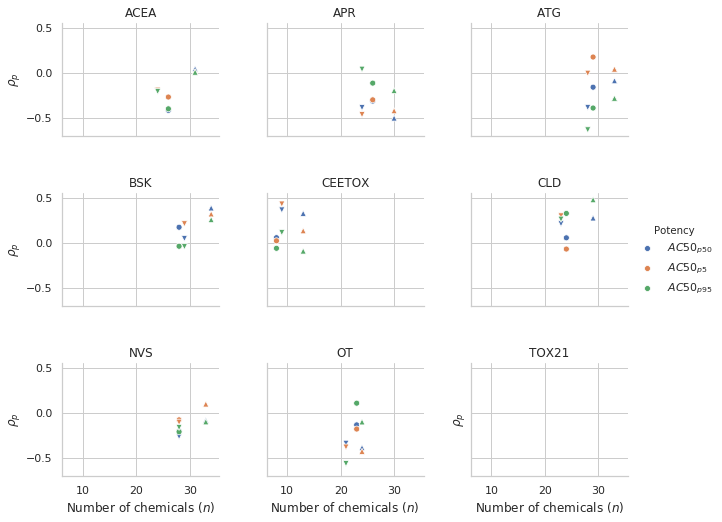

In [63]:
sns.set(font_scale=1.0,style='whitegrid')

g = sns.FacetGrid(col='platform_y',col_wrap=3,
                   data=HepRnTxTch_cmp.rename(columns=dict(potency_name='Potency')), 
                   hue='Potency',
                   height=3,
                   legend_out=True,
              )
s1 = g.map_dataframe(sns.scatterplot, 'n_chem','R_p', style='timeh_x',markers=['o','v','^'])
g.set_titles(row_template='{row_name}',col_template='{col_name}')
g.add_legend()
g.set(xlabel=r'Number of chemicals ($n$)',
      ylabel=r'$\rho_p$',
     )
pl.subplots_adjust(wspace=0.3,hspace=0.5,top=0.8,bottom=0.1)

g.fig.savefig(FIG_DIR+'figure-heprn-vs-toxcast-tech.png',dpi=200)
g.fig.savefig(FIG_DIR+'figure-heprn-vs-toxcast-tech.svg',dpi=200)

## S5: ToxCast Potency

In [ ]:
X = pd.DataFrame(HCI.potency.find(dict(assay='ToxCast',
                                       potency_name='ac50_p05',
                                       potency_meth='tcpl:ac50:manual_qc'),
                                  dict(_id=0)))


X1 = X.groupby(['dsstox_sid','name','platform'])\
               .aggregate(dict(potency_val=[_p05,_p50,_p95]))
X1.columns= [i.replace('potency_val','ac50')+j for i,j in X1.columns]
X1 = X1.reset_index()
X2 = X.groupby(['dsstox_sid','name'])\
               .aggregate(dict(potency_val=[_p05,_p50,_p95]))
X2.columns= [i.replace('potency_val','ac50')+j for i,j in X2.columns]
X2 = X2.reset_index()

X2.insert(2,'platform','All')

SuppTab5 = pd.concat((X1,X2)).sort_values(['name','platform'])

SuppTab5.to_excel(SUP_DIR+'S5-toxcast-ac50.xlsx')


# *In vivo* Effects and PODs

In [46]:
LIV_EFF = pd.DataFrame(HCI.rat_effects_v2.find({},dict(_id=0)))

ST = dict(SUB='Subchronic', CHR='Chronic')
LIV_EFF.replace(dict(study_type=ST),inplace=True)
EF2 = LIV_EFF.groupby(['effect_desc']).aggregate(dict(pod_value=[_p05,_p50,_p95,_n]))
EF2.columns=[i+j for i,j in EF2.columns]
EF2 = EF2[EF2.pod_value_n>0].reset_index().sort_values('pod_value_n',ascending=False)
EF2.head()

,effect_desc,pod_value_p05,pod_value_p50,pod_value_p95,pod_value_n
14,Hepatomegaly,7.15,162.4,1255.29,190.0
16,Hypertrophy,4.81,232.7,1055.00,94.0
22,Other,21.21,100.0,1218.87,80.0
26,Vacuolization,9.17,65.8,1088.38,26.0
9,Fatty change,5.20,25.0,1813.82,22.0


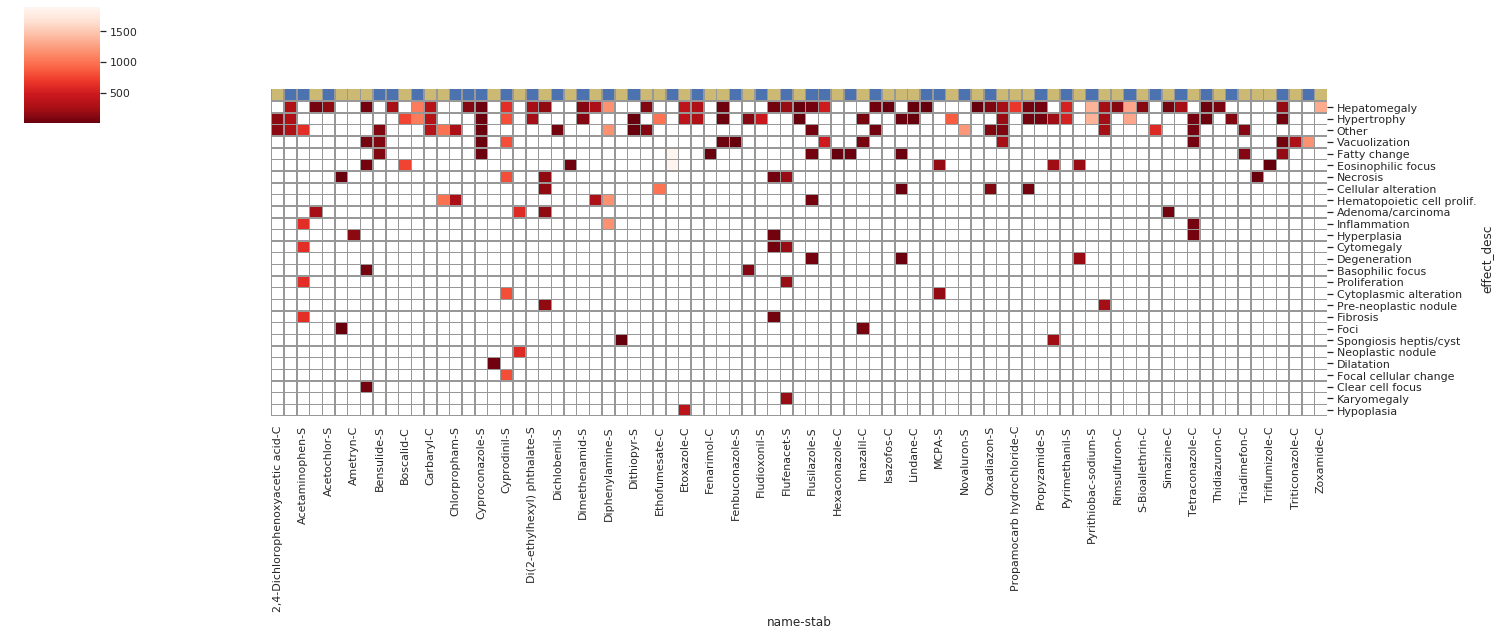

In [48]:
if 'stab' not in LIV_EFF:
    LIV_EFF.insert(0,'stab',LIV_EFF.study_type.str[:1])
LIV1 = LIV_EFF.pivot_table(index=['name','stab'],
                           columns='effect_desc',
                           values='pod_value')
N = LIV1.notnull().sum(axis=0).sort_values(ascending=False)
LIV1 = LIV1[N.index]
ST = ['b' if i=='S' else 'y' for i in LIV1.reset_index().stab]
g= sns.clustermap(LIV1.T,
                  col_colors=ST,
                  col_cluster=False, row_cluster=False,
                  linewidth=0.5,linecolor='#989898',
                  figsize=(21,9),cmap=cm.Reds_r)
g.savefig(FIG_DIR+'chemical-liver-effects.svg')
g.savefig(FIG_DIR+'chemical-liver-effects.png',dpi=300)

## Distribution of PODs by Effect

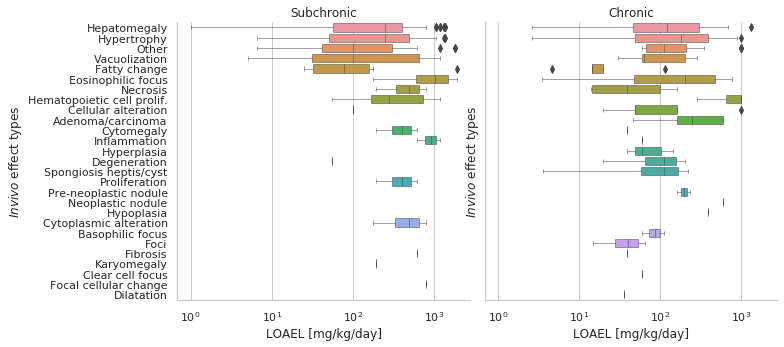

In [90]:
g = sns.catplot(y='effect_desc',x='pod_value',data=LIV_EFF,
                col='study_type',col_wrap=2,col_order=['Subchronic','Chronic'],
                order=EF2.effect_desc,
                height=5.5,
                kind='box',orient='h',
                linewidth=0.5,width=0.8)
#g.set(xticks=[0,5,10,25,50,75])
g.set(xlabel=r'LOAEL [mg/kg/day]',
      ylabel=r'$In vivo$ effect types',
     )
g.set_titles(row_template='{row_name}',col_template='{col_name}')
g.set(xscale='log')
pl.subplots_adjust(wspace=0.05,hspace=0.03,top=0.8,bottom=0.1)

## Table 3. Distribution of PODs by Effect

In [163]:
X1= LIV_EFF.groupby(['study_type','effect_desc']).aggregate(dict(pod_value=[np.mean,np.std],
                                                                dsstox_sid=lambda x: len(set(x))))
#X1.columns=['LOAEL']
X1.head()
X1.reset_index()
A = X1.query("study_type=='Chronic'")
B = X1.query("study_type=='Subchronic'")
X2 = A.merge(B,on='effect_desc',how='outer')
X2.sort_values(X2.columns[-1],ascending=False).to_excel(DAT_DIR+"table-3b.xlsx")

In [162]:
LIV_EFF.groupby(['study_type']).aggregate(dict(pod_value=[np.mean,np.std],
                                                                dsstox_sid=lambda x: len(set(x))))

pod_value         dsstox_sid
                mean     std   <lambda>
study_type                             
Chronic       218.46  267.97         45
Subchronic    387.28  465.91         38

## Supplemental S1: POD

In [55]:
def _p05(X):  return np.percentile(X,5)
def _p95(X): return np.percentile(X,95)
def _p50(X): return np.percentile(X,50)

Dur = dict(SUB=90,CHR=365*2)
Y = pd.DataFrame(HCI.rat_effects_v2.find({},dict(_id=0)))

LIV_EFF1_W = Y.pivot_table(index=['name','dsstox_sid','casrn','study_type'],
                   columns=['effect_desc'],
                   values='pod_value',
                   aggfunc=np.min)

TOX_POD = Y.groupby(['name','dsstox_sid','casrn','study_type'])\
            .aggregate(dict(pod_value=[_p05,_p50,_p95]))
TOX_POD.columns = ['loael'+j for i,j in TOX_POD.columns]

SuppTab1 = LIV_EFF1_W.merge(TOX_POD,left_index=True,right_index=True)
SuppTab1.to_excel(SUP_DIR+'S1-toxref-loeal-suppl-table.xlsx')

# IVIVE Performance

## Figure 7: Compare across assays and IVIVE methods

In [56]:
HCI.performance.distinct('assay')

['HepRn', 'HepRnAtg', 'ToxCast']

In [19]:
Q = {'$and':[{'$or':[dict(assay='HepRn',platform='APR:HepRn:Tm'),
                    dict(assay='HepRnAtg'),
                    dict(assay='ToxCast',platform='All')
                   ]},
             dict(potency_meth='tcpl:ac50:manual_qc',
                  potency_name='ac50_p05',
                  #ft='All',
                  effect='All',
                  pod_name='loael_p05')
            ]}

FX = ['study_type','assay','platform','ft','ivive_method',
      'potency_meth',u'dose_metric',
      'potency_name','pod_name','effect','days_ivt']

PERF = pd.DataFrame(HCI.performance.find(Q,dict(_id=0)))\
         .melt(id_vars=FX)
PERF.head()

,study_type,assay,platform,ft,ivive_method,potency_meth,dose_metric,potency_name,pod_name,effect,days_ivt,variable,value
0,SUB,HepRn,APR:HepRn:Tm,All,css,tcpl:ac50:manual_qc,q0.05,ac50_p05,loael_p05,All,1.0,RMSE,9.84
1,SUB,HepRn,APR:HepRn:Tm,All,css,tcpl:ac50:manual_qc,q0.05,ac50_p05,loael_p05,All,2.0,RMSE,8.07
2,SUB,HepRn,APR:HepRn:Tm,All,css,tcpl:ac50:manual_qc,q0.05,ac50_p05,loael_p05,All,3.0,RMSE,8.94
3,SUB,HepRn,APR:HepRn:Tm,All,css,tcpl:ac50:manual_qc,q0.50,ac50_p05,loael_p05,All,1.0,RMSE,11.41
4,SUB,HepRn,APR:HepRn:Tm,All,css,tcpl:ac50:manual_qc,q0.50,ac50_p05,loael_p05,All,2.0,RMSE,9.33


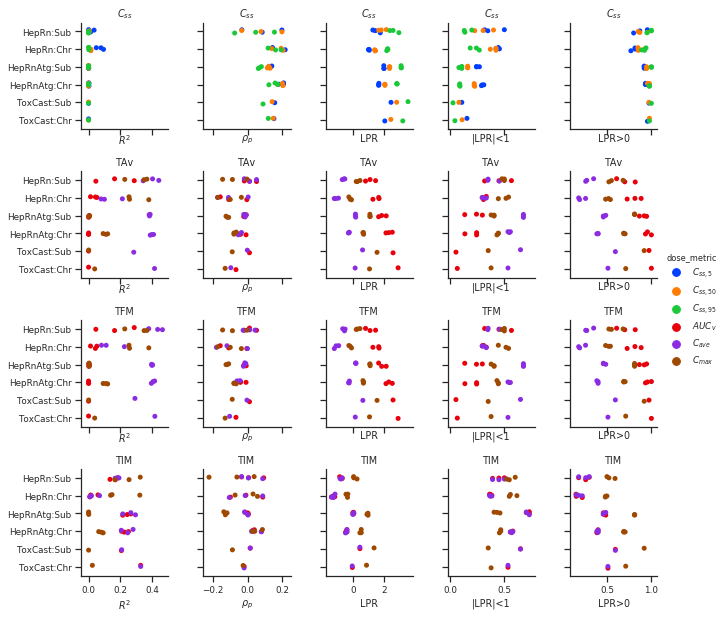

In [30]:
sns.set(style='ticks',font_scale=0.8)
#sns.set_context('paper')
DM = dict(cave='$C_{ave}$',cmax='$C_{max}$', auc='$AUC_v$')
DM['q0.05']='$C_{ss,5}$'
DM['q0.50']='$C_{ss,50}$'
DM['q0.95']='$C_{ss,95}$'
ST = dict(SUB='Subchronic', CHR='Chronic')

IM = {'time-averaged':'TAv', 'time-final-matched':'TFM', 'time-matched':'TIM', 'css':r'$C_{ss}$'}

V = ['R2','R_p','LPR','LPR_lt_1', 'Underpred']
X = PERF[(PERF.variable.isin(V))]
X.insert(0,'assay_study',X.assay+':'+X.study_type.str.lower().str.capitalize())

as_cats = pd.api.types.CategoricalDtype(categories=['HepRn:Sub', 'HepRn:Chr',
                                                    'HepRnAtg:Sub', 'HepRnAtg:Chr', 
                                                    'ToxCast:Sub','ToxCast:Chr'],
                                        ordered=True)
X.loc[:,'assay_study']=X.assay_study.astype(as_cats)


X.replace(dict( dose_metric=DM,
                variable=dict(R2='$R^2$',R_p=r'$\rho_p$',
                             LPR_lt_1='|LPR|<1',Underpred='LPR>0'),
               ivive_method=IM
              ),
          inplace=True
         )
g=sns.catplot(y='assay_study',x='value',
              data=X,
              row='ivive_method',col='variable',hue='dose_metric',
              height=3.2,aspect=0.6,
              sharex='col',kind='strip',
              palette='bright',
              legend_out=True,
              linewidth=0
               )
g.set(ylabel='',xlabel='')
#g.map(pl.hlines,range(7),[])
#g.set(yscale='log')
pl.subplots_adjust(wspace=0.4,hspace=0.4,top=0.8,bottom=0.2)
g.set_titles(row_template='{row_name}',col_template='{col_name}')
for ax in g.axes.flat:
    ti,xl = ax.get_title().split(' | ')
    ax.set_xlabel(xl)
    ax.set_title(ti)
    
g.savefig(FIG_DIR+'perf-3.png',dpi=300)
g.savefig(FIG_DIR+'perf-3.svg')

## Compare ft withing Assays

In [240]:
Q = {'$and':[{'$or':[dict(assay='HepRn',platform='APR:HepRn:Tm:Ft'),
                   ]},
             dict(potency_meth='tcpl:ac50:manual_qc',
                  #potency_name='ac50_p05',
                  #pod_name='loael_p05'
                 )
            ]}

FX = ['study_type','assay','platform','ft','ivive_method',
      'potency_meth',u'dose_metric',
      'potency_name','pod_name','effect','days_ivt']

PERF = pd.DataFrame(HCI.performance.find(Q,dict(_id=0)))\
         .melt(id_vars=FX)
PERF.head()

,study_type,assay,platform,ft,ivive_method,potency_meth,dose_metric,potency_name,pod_name,effect,days_ivt,variable,value
0,SUB,HepRn,APR:HepRn:Tm:Ft,Ap,css,tcpl:ac50:manual_qc,q0.05,ac50_p05,loael_p05,All,1.0,RMSE,3.83
1,SUB,HepRn,APR:HepRn:Tm:Ft,Ap,css,tcpl:ac50:manual_qc,q0.05,ac50_p05,loael_p05,All,3.0,RMSE,3.22
2,SUB,HepRn,APR:HepRn:Tm:Ft,Ap,css,tcpl:ac50:manual_qc,q0.05,ac50_p05,loael_p05,Fatty change,1.0,RMSE,2.36
3,SUB,HepRn,APR:HepRn:Tm:Ft,Ap,css,tcpl:ac50:manual_qc,q0.05,ac50_p05,loael_p05,Hepatomegaly,1.0,RMSE,3.74
4,SUB,HepRn,APR:HepRn:Tm:Ft,Ap,css,tcpl:ac50:manual_qc,q0.05,ac50_p05,loael_p05,Hypertrophy,1.0,RMSE,1.03


## Scatterplots

### Figure 6: HepRn

In [32]:
Q = {'$and':[{'$or':[dict(assay='HepRn',platform='APR:HepRn:Tm'),
                   ]},
             dict(potency_meth='tcpl:ac50:manual_qc',
                  potency_name='ac50_p05',
                  pod_name='loael_p05',
                  effect='All'
                 )
            ]}

FX = ['study_type','assay','platform','ft','ivive_method',
      'potency_meth',u'dose_metric',
      'potency_name','pod_name','effect','days_ivt']

HepRn = pd.DataFrame(HCI.potency_aed_pod.find(Q,dict(_id=0)))
HepRn.head().T

,0,1,2,3,4
aed,6.3e+02,1.9e+04,2.2e+03,6.3e+02,1.9e+04
casrn,34256-82-1,34256-82-1,34256-82-1,34256-82-1,34256-82-1
days_ivt,3,3,3,3,3
days_ivv,90,90,90,90,90
dose_ivt,69,69,69,69,69
dose_metric,auc,cave,cmax,auc,cave
dsstox_sid,DTXSID8023848,DTXSID8023848,DTXSID8023848,DTXSID8023848,DTXSID8023848
ivive_method,time-averaged,time-averaged,time-averaged,time-final-matched,time-final-matched
name,Acetochlor,Acetochlor,Acetochlor,Acetochlor,Acetochlor
potency_name,ac50_p05,ac50_p05,ac50_p05,ac50_p05,ac50_p05


In [33]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

def mycorr(x, y, **kws):
    nna = x.notna() & y.notna()
    r,p= sp.stats.pearsonr(x[nna], y[nna])
    return r
    
def corrfunc(x, y, **kws):
    nna = x.notna() & y.notna()
    r,p = sp.stats.pearsonr(x[nna], y[nna])
    ax = plt.gca()
    ax.annotate(r"$\rho$={:.2f}".format(r),#+r"({:.2f})".format(p),
                xy=(.1, .9), size=8,
                xycoords=ax.transAxes)

def mr2_score(x,y, **kws):
    nna = x.notna() & y.notna()
    r = r2_score(np.log10(x[nna]), np.log10(y[nna]))
    ax = plt.gca()
    ax.annotate(r"$R^2$={:.2f}".format(r),
                xy=(.1, .8), size=8,
                xycoords=ax.transAxes)
    
    
# def overunder(x,y, **kws):
#     nna  = x.notna() & y.notna()
#     over = np.sum(y[nna]>x[nna])
#     under = np.sum(y[nna]<x[nna])
#     ax = plt.gca()
#     ax.annotate(r"over:%i under:%i" % (over,under),
#                 xy=(.5, .03), size=8,
#                 xycoords=ax.transAxes)
    
def overunder(x,y, yname='',xname='',**kwds):
    nna  = x.notna() & y.notna()
    ygtx = np.sum(y[nna]>x[nna])
    xgty = np.sum(x[nna]>y[nna])
    ax = plt.gca()
    ax.annotate(r"%s>:%i %s>:%i" % (xname,xgty,yname,ygtx),
                xy=(.5, .03), size=8,
                xycoords=ax.transAxes)


def fold(x,y, **kws):
    nna  = x.notna() & y.notna()
    fld  = 10**np.mean(np.log10(y[nna])-np.log10(x[nna]))
    ax = plt.gca()
    ax.annotate(r"$invivo/invitro$:%.2f" % fld,
                xy=(.5, .13), size=8,
                xycoords=ax.transAxes)

time-matched


/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150:

time-averaged


/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150:

time-final-matched


/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150:

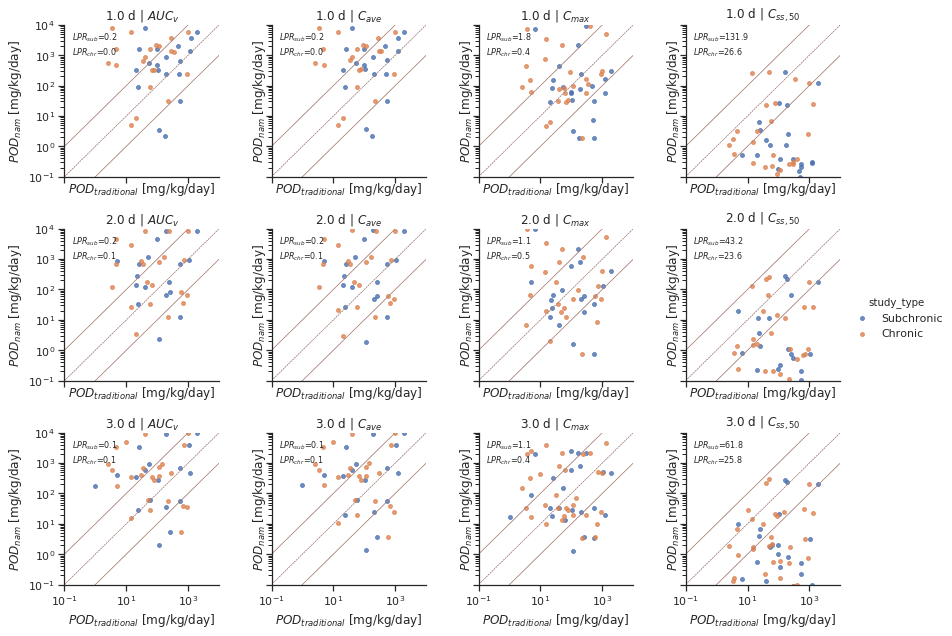

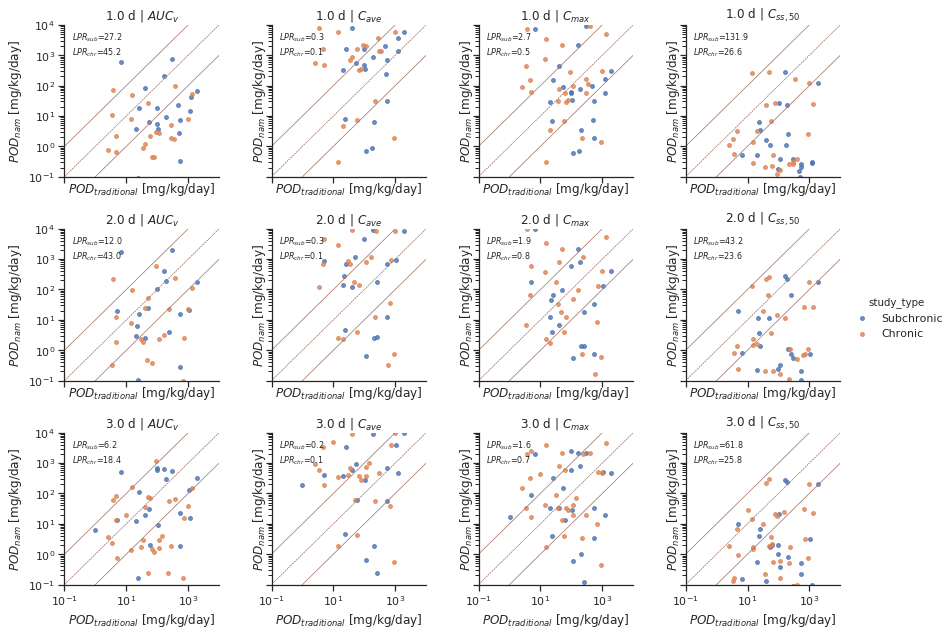

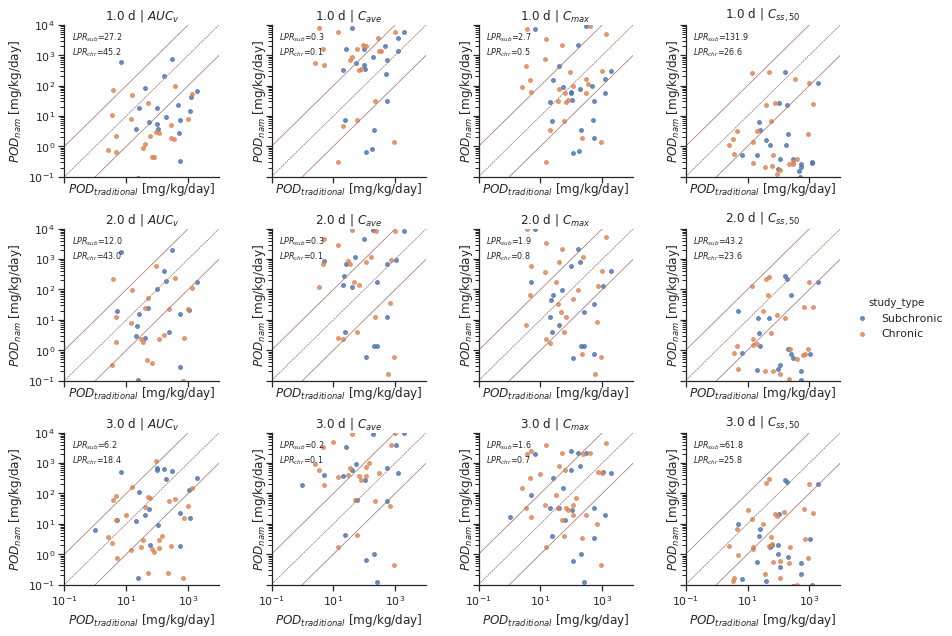

In [34]:
sns.set(font_scale=1,style='ticks')
conf = 0.5

Pl_y='aed'
Pl_x='pod_value'

DM = dict(cave='$C_{ave}$',cmax='$C_{max}$', auc='$AUC_v$')
DM['q0.50']='$C_{ss,50}$'
ST = dict(SUB='Subchronic', CHR='Chronic')

def ratio(x,y, **kws):
    YST = dict(Subchronic=0.9,Chronic=0.8)
    Lab = dict(Subchronic='sub',Chronic='chr')
    nna  = x.notna() & y.notna()
    st = kws['label']
    fld  = 10**np.mean(np.log10(x[nna])-np.log10(y[nna]))
    ax = plt.gca()
    ax.annotate(r"$LPR_{%s}$=%.1f" % (Lab.get(st),fld),
                xy=(.05, YST[st]), size=8,
                xycoords=ax.transAxes)

for meth in ['time-matched','time-averaged','time-final-matched']:
    print(meth)
    X = HepRn.copy()
    X = X[(X.days_ivt>=1) & 
          (X.dose_metric.isin(['cave','cmax','auc','q0.50'])) &      
          (X.ivive_method.isin([meth,'css']))]

    X.replace(dict(dose_metric=DM,study_type=ST),inplace=True)
    g=sns.FacetGrid(X,
                    col='dose_metric',row='days_ivt',hue='study_type',
                    height=3,aspect=1,
                    legend_out=True
                   )
    g.map(pl.scatter,Pl_x,Pl_y,s=15,alpha=0.8)
    g.map(ratio,Pl_x,Pl_y)
    x1 = np.logspace(-1,6,num=6)
    y2 = 10**(np.log10(x1)+1)
    y3 = 10**(np.log10(x1)-1)
    g.map_dataframe(pl.plot,x1,x1,'--',linewidth=0.5)
    g.map_dataframe(pl.plot,x1,y2,'-',linewidth=0.5)
    g.map_dataframe(pl.plot,x1,y3,'-',linewidth=0.5)
    g.set_titles(row_template='{row_name} d',col_template='{col_name}')
    g.set(xscale='log',yscale='log',xlim=[1e-1,1e4],ylim=[1e-1,1e4])
    g.set(ylabel=r'$POD_{nam}$ [mg/kg/day]',
          xlabel=r'$POD_{traditional}$ [mg/kg/day]'
         )
    g.fig.tight_layout()
    g.add_legend()
    g.savefig(FIG_DIR+'figure-6-%s-heprn-loael-p5.png' % meth,dpi=600)
    g.savefig(FIG_DIR+'figure-6-%s-heprn-loael-p5.svg' % meth)

### Figure 6: ToxCast 

In [36]:
Q = {'$and':[{'$or':[dict(assay='ToxCast',platform='All'),
                   ]},
             dict(potency_meth='tcpl:ac50:manual_qc',
                  potency_name='ac50_p05',
                  pod_name='loael_p05',
                  effect='All'
                 )
            ]}

FX = ['study_type','assay','platform','ft','ivive_method',
      'potency_meth',u'dose_metric',
      'potency_name','pod_name','effect','days_ivt']

ToxCast = pd.DataFrame(HCI.potency_aed_pod.find(Q,dict(_id=0)))
ToxCast.head().T

,0,1,2,3,4
aed,0.0035,0.31,0.22,0.0035,0.31
casrn,94-75-7,94-75-7,94-75-7,94-75-7,94-75-7
days_ivt,1,1,1,1,1
days_ivv,90,90,90,90,90
dose_ivt,7.9,7.9,7.9,7.9,7.9
dose_metric,auc,cave,cmax,auc,cave
dsstox_sid,DTXSID0020442,DTXSID0020442,DTXSID0020442,DTXSID0020442,DTXSID0020442
ivive_method,time-averaged,time-averaged,time-averaged,time-final-matched,time-final-matched
name,"2,4-Dichlorophenoxyacetic acid","2,4-Dichlorophenoxyacetic acid","2,4-Dichlorophenoxyacetic acid","2,4-Dichlorophenoxyacetic acid","2,4-Dichlorophenoxyacetic acid"
potency_name,ac50_p05,ac50_p05,ac50_p05,ac50_p05,ac50_p05


time-matched


/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotl

time-averaged


/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotl

time-final-matched


/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotl

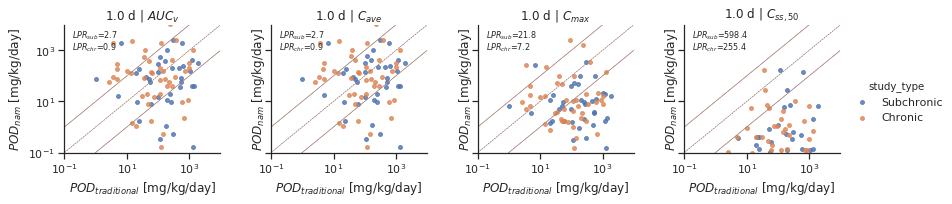

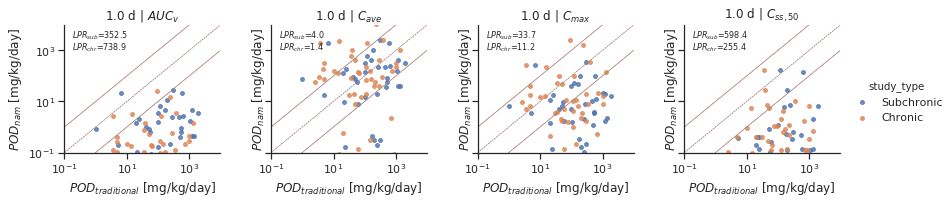

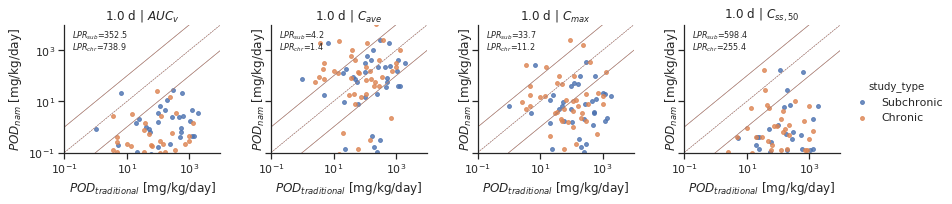

In [38]:
sns.set(font_scale=1,style='ticks')
conf = 0.5

Pl_y='aed'
Pl_x='pod_value'

DM = dict(cave='$C_{ave}$',cmax='$C_{max}$', auc='$AUC_v$')
DM['q0.50']='$C_{ss,50}$'
ST = dict(SUB='Subchronic', CHR='Chronic')

def ratio(x,y, **kws):
    YST = dict(Subchronic=0.9,Chronic=0.8)
    Lab = dict(Subchronic='sub',Chronic='chr')
    nna  = x.notna() & y.notna()
    st = kws['label']
    fld  = 10**np.mean(np.log10(x[nna])-np.log10(y[nna]))
    ax = plt.gca()
    ax.annotate(r"$LPR_{%s}$=%.1f" % (Lab.get(st),fld),
                xy=(.05, YST[st]), size=8,
                xycoords=ax.transAxes)

for meth in ['time-matched','time-averaged','time-final-matched']:
    print(meth)
    X = ToxCast.copy()
    X = X[(X.days_ivt>=1) & 
          (X.dose_metric.isin(['cave','cmax','auc','q0.50'])) &      
          (X.ivive_method.isin([meth,'css']))]

    X.replace(dict(dose_metric=DM,study_type=ST),inplace=True)
    g=sns.FacetGrid(X,
                    col='dose_metric',row='days_ivt',hue='study_type',
                    height=3,aspect=1,
                    legend_out=True
                   )
    g.map(pl.scatter,Pl_x,Pl_y,s=15,alpha=0.8)
    g.map(ratio,Pl_x,Pl_y)
    x1 = np.logspace(-1,6,num=6)
    y2 = 10**(np.log10(x1)+1)
    y3 = 10**(np.log10(x1)-1)
    g.map_dataframe(pl.plot,x1,x1,'--',linewidth=0.5)
    g.map_dataframe(pl.plot,x1,y2,'-',linewidth=0.5)
    g.map_dataframe(pl.plot,x1,y3,'-',linewidth=0.5)
    g.set_titles(row_template='{row_name} d',col_template='{col_name}')
    g.set(xscale='log',yscale='log',xlim=[1e-1,1e4],ylim=[1e-1,1e4])
    g.set(ylabel=r'$POD_{nam}$ [mg/kg/day]',
          xlabel=r'$POD_{traditional}$ [mg/kg/day]'
         )
    g.fig.tight_layout()
    g.add_legend()
    g.savefig(FIG_DIR+'figure-6-%s-toxcast-loael-p5.png' % meth,dpi=600)
    g.savefig(FIG_DIR+'figure-6-%s-toxcast-loael-p5.svg' % meth)

### Figure S6: HepRnAtg

In [66]:
Q = {'$and':[{'$or':[dict(assay='HepRnAtg'),
                   ]},
             dict(potency_meth='tcpl:ac50:manual_qc',
                  potency_name='ac50_p05',
                  pod_name='loael_p05',
                  effect='All'
                 )
            ]}

FX = ['study_type','assay','platform','ft','ivive_method',
      'potency_meth',u'dose_metric',
      'potency_name','pod_name','effect','days_ivt']

HepRnAtg = pd.DataFrame(HCI.potency_aed_pod.find(Q,dict(_id=0)))
HepRnAtg.head().T

,0,1,2,3,4
aed,0.02,1.8,1.3,0.02,1.8
casrn,94-75-7,94-75-7,94-75-7,94-75-7,94-75-7
days_ivt,1,1,1,1,1
days_ivv,90,90,90,90,90
dose_ivt,46,46,46,46,46
dose_metric,auc,cave,cmax,auc,cave
dsstox_sid,DTXSID0020442,DTXSID0020442,DTXSID0020442,DTXSID0020442,DTXSID0020442
ivive_method,time-averaged,time-averaged,time-averaged,time-final-matched,time-final-matched
name,"2,4-Dichlorophenoxyacetic acid","2,4-Dichlorophenoxyacetic acid","2,4-Dichlorophenoxyacetic acid","2,4-Dichlorophenoxyacetic acid","2,4-Dichlorophenoxyacetic acid"
potency_name,ac50_p05,ac50_p05,ac50_p05,ac50_p05,ac50_p05


time-matched


/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150:

time-averaged


/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150:

time-final-matched


/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/seaborn/axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/matplotlib/text.py:1150:

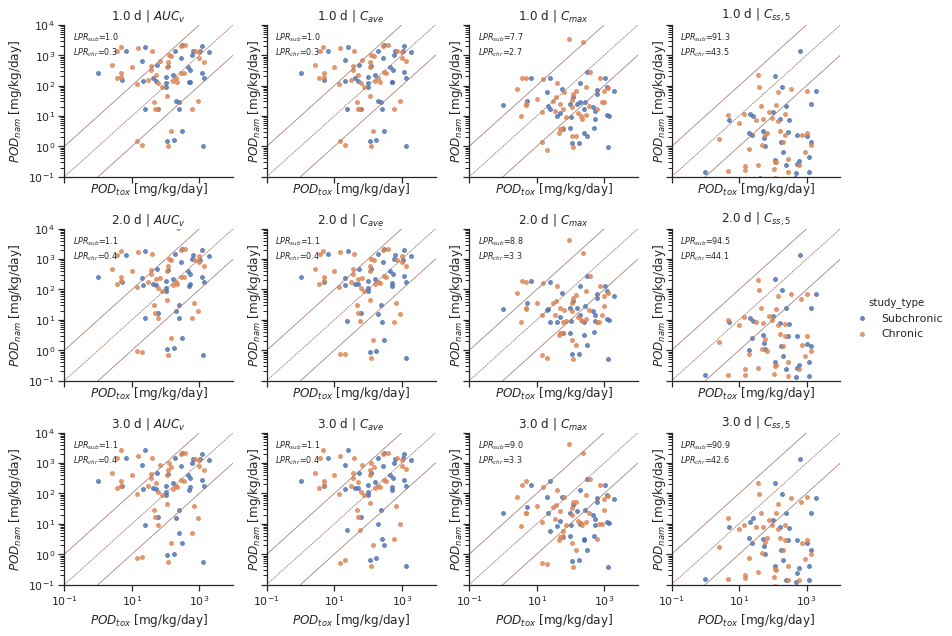

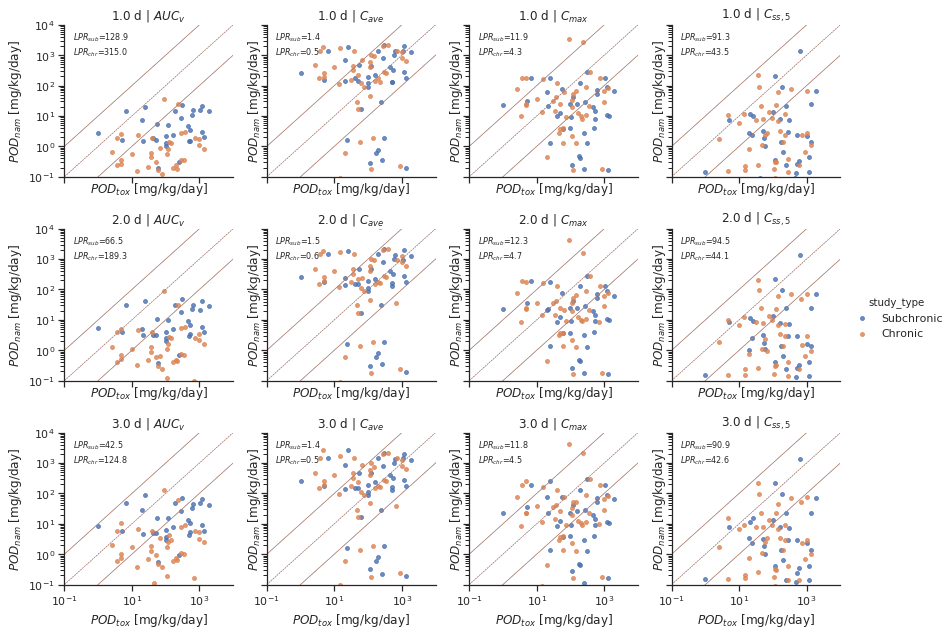

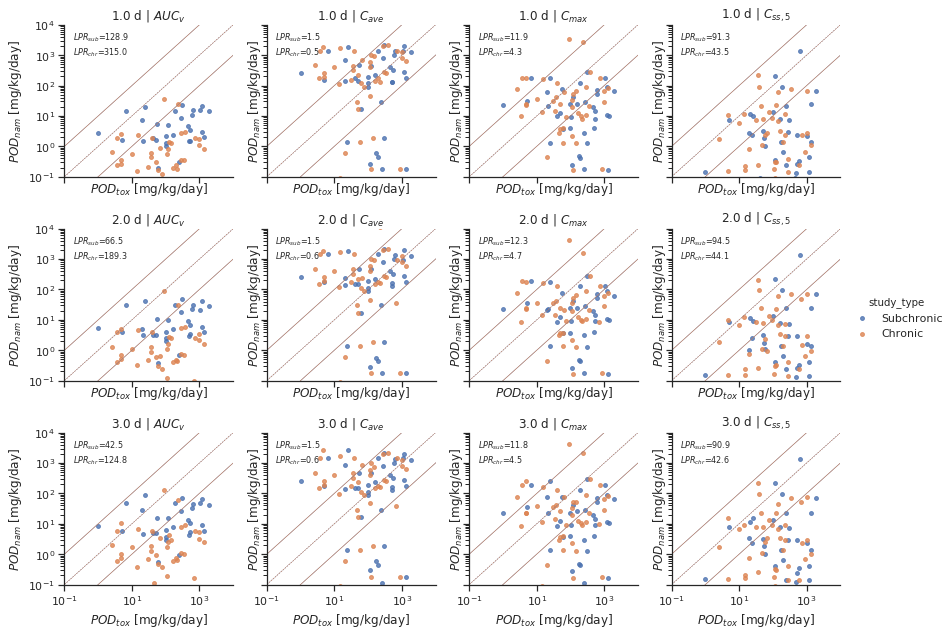

In [67]:
sns.set(font_scale=1,style='ticks')
conf = 0.5

Pl_y='aed'
Pl_x='pod_value'

DM = dict(cave='$C_{ave}$',cmax='$C_{max}$', auc='$AUC_v$')
DM['q0.05']='$C_{ss,5}$'
ST = dict(SUB='Subchronic', CHR='Chronic')

def ratio(x,y, **kws):
    YST = dict(Subchronic=0.9,Chronic=0.8)
    Lab = dict(Subchronic='sub',Chronic='chr')
    nna  = x.notna() & y.notna()
    st = kws['label']
    fld  = 10**np.mean(np.log10(x[nna])-np.log10(y[nna]))
    ax = plt.gca()
    ax.annotate(r"$LPR_{%s}$=%.1f" % (Lab.get(st),fld),
                xy=(.05, YST[st]), size=8,
                xycoords=ax.transAxes)

for meth in ['time-matched','time-averaged','time-final-matched']:
    print(meth)
    X = HepRnAtg.copy()
    X = X[(X.days_ivt>=1) & 
          (X.dose_metric.isin(['cave','cmax','auc','q0.05'])) &      
          (X.ivive_method.isin([meth,'css']))]

    X.replace(dict(dose_metric=DM,study_type=ST),inplace=True)
    g=sns.FacetGrid(X,
                    col='dose_metric',row='days_ivt',hue='study_type',
                    height=3,aspect=1,
                    legend_out=True
                   )
    g.map(pl.scatter,Pl_x,Pl_y,s=15,alpha=0.8)
    g.map(ratio,Pl_x,Pl_y)
    x1 = np.logspace(-1,6,num=6)
    y2 = 10**(np.log10(x1)+1)
    y3 = 10**(np.log10(x1)-1)
    g.map_dataframe(pl.plot,x1,x1,'--',linewidth=0.5)
    g.map_dataframe(pl.plot,x1,y2,'-',linewidth=0.5)
    g.map_dataframe(pl.plot,x1,y3,'-',linewidth=0.5)
    g.set_titles(row_template='{row_name} d',col_template='{col_name}')
    g.set(xscale='log',yscale='log',xlim=[1e-1,1e4],ylim=[1e-1,1e4])
    g.set(ylabel=r'$POD_{nam}$ [mg/kg/day]',
          xlabel=r'$POD_{tox}$ [mg/kg/day]'
         )
    g.fig.tight_layout()
    g.add_legend()
    g.savefig(FIG_DIR+'figure-S6-%s-heprnatg-loael-p5.png' % meth,dpi=600)
    g.savefig(FIG_DIR+'figure-S6-%s-heprnatg-loael-p5.svg' % meth)

# Figure 9: LPR and Effects 

Set the study type for *Q* and the modify the figure name under Draw

In [120]:
Study = 'SUB'
C0 = [u'LM',u'ES',u'St',u'MF',u'DT',  u'NS', u'Ap', u'CN']

Q = {'$and':[{'$or':[dict(assay='HepRn',platform='APR:HepRn:Tm:Ft'),
                   ]},
             dict(potency_meth='tcpl:ac50:manual_qc',
                  potency_name='ac50_p05',
                  ivive_method='time-averaged',
                  study_type=Study,
                  effect={'$nin':['All','Other']},
                  pod_name='loael_p05'
                 )
            ]}

FX = ['study_type','assay','platform','ft','ivive_method',
      'potency_meth',u'dose_metric',
      'potency_name','pod_name','effect','days_ivt']

PERF = pd.DataFrame(HCI.potency_aed_pod.find(Q,dict(_id=0)))
PERF.insert(PERF.shape[1],'LPR',np.log10(PERF.pod_value/PERF.aed))

Y = PERF.groupby('effect').aggregate(dict(LPR=np.mean))\
     .sort_values('LPR',ascending=True)

N = PERF.groupby('effect').aggregate(dict(name=lambda x: len(set(x))))\
     .loc[Y.index]
N2 = PERF.groupby('ft').aggregate(dict(name=lambda x: len(set(x))))\
     .loc[C0]
effect_cats = pd.api.types.CategoricalDtype(categories=Y.index,
                                            ordered=True)
PERF.loc[:,'effect']=PERF.effect.astype(effect_cats)

ft_cats = pd.api.types.CategoricalDtype(categories=C0,ordered=True)
PERF.loc[:,'ft']=PERF.ft.astype(ft_cats)
PERF1 = PERF.groupby(['study_type','assay','platform','ft','ivive_method',
                      'potency_meth',u'dose_metric',
                      'potency_name','pod_name','effect'])\
            .aggregate(dict(LPR=np.mean,name=lambda i: len(set(i)))).reset_index()
PERF1.loc[:,'effect']=PERF1.effect.astype(effect_cats)

PERF1.loc[:,'ft']=PERF1.ft.astype(ft_cats)

PERF1.insert(PERF1.shape[1],'i_effect',PERF1.effect.replace(dict(zip(Y.index,range(len(Y))))))
PERF1.insert(PERF1.shape[1],'i_ft',PERF1.ft.replace(dict(zip(C0,range(len(C0))))))

# PERF1_lpr = PERF1.pivot_table(index=['effect'],columns=['ft'],values='LPR',
#                               aggfunc=np.mean)\
#                  .loc[Y.index,C0]
# PERF1_n = PERF1.pivot_table(index=['effect'],columns=['ft'],values='name',aggfunc
#                             =np.median)\
#                 .loc[Y.index,C0]



In [121]:
PERF.head()

,aed,casrn,days_ivt,days_ivv,dose_ivt,dose_metric,dsstox_sid,ivive_method,name,potency_name,ft,assay,platform,potency_meth,study_type,pod_name,effect,pod_value,LPR
0,411.22,34256-82-1,2.0,90,68.06,auc,DTXSID8023848,time-averaged,Acetochlor,ac50_p05,MF,HepRn,APR:HepRn:Tm:Ft,tcpl:ac50:manual_qc,SUB,loael_p05,Hepatomegaly,161.1,-0.41
1,18699.62,34256-82-1,2.0,90,68.06,cave,DTXSID8023848,time-averaged,Acetochlor,ac50_p05,MF,HepRn,APR:HepRn:Tm:Ft,tcpl:ac50:manual_qc,SUB,loael_p05,Hepatomegaly,161.1,-2.06
2,2142.15,34256-82-1,2.0,90,68.06,cmax,DTXSID8023848,time-averaged,Acetochlor,ac50_p05,MF,HepRn,APR:HepRn:Tm:Ft,tcpl:ac50:manual_qc,SUB,loael_p05,Hepatomegaly,161.1,-1.12
3,666.57,34256-82-1,3.0,90,73.55,auc,DTXSID8023848,time-averaged,Acetochlor,ac50_p05,ES,HepRn,APR:HepRn:Tm:Ft,tcpl:ac50:manual_qc,SUB,loael_p05,Hepatomegaly,161.1,-0.62
4,20207.77,34256-82-1,3.0,90,73.55,cave,DTXSID8023848,time-averaged,Acetochlor,ac50_p05,ES,HepRn,APR:HepRn:Tm:Ft,tcpl:ac50:manual_qc,SUB,loael_p05,Hepatomegaly,161.1,-2.10


## Draw

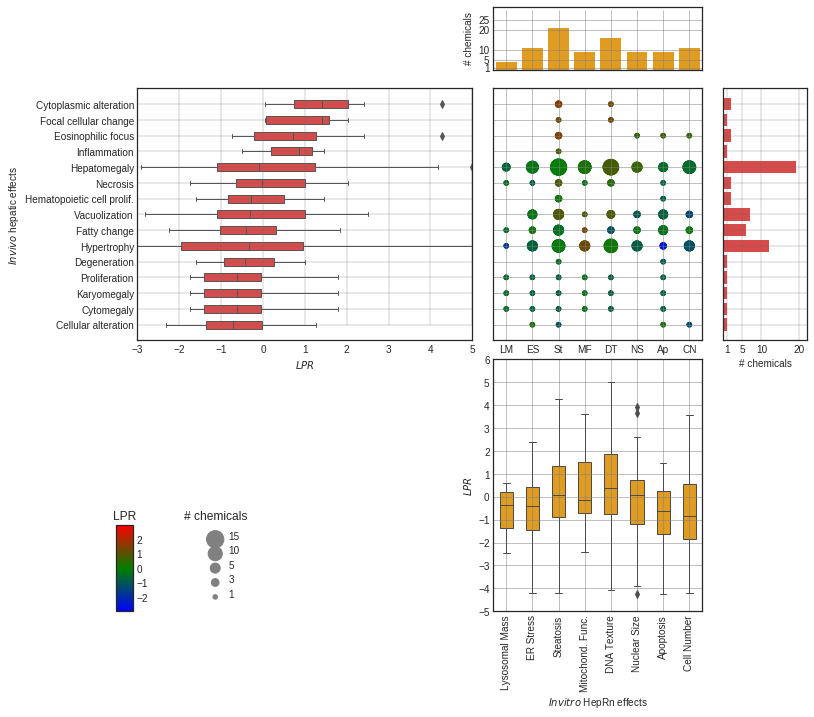

In [124]:

fig=pl.figure(figsize=(12,12))
gs1 = gridspec.GridSpec(3,3,width_ratios=[0.8,0.5,0.2],
                        height_ratios=[0.2,0.8,0.8])

col1 = '#ef3434'
col2 = 'orange'


# Boxplots for effects

ax = pl.subplot(gs1[1,0])

g = sns.boxplot(y='effect',x='LPR',
                #hue='dose_metric',
                data=PERF,color=col1,
                linewidth=1,width=0.5,
                ax = ax
               )

ax.set_xticks([-3,-2,-1,0,1,2,3,4,5])
ax.vlines([-3,-2,-1,0,1,2,3,4,5],0,len(N)+0.5,
          linewidth=0.3,linestyle='-',color='#676767')
ax.hlines(np.arange(0,len(N)),-4,5,
          linewidth=0.3,linestyle='-',color='#676767')
ax.set_xlabel(r'$LPR$')
ax.set_ylabel('$In vivo$ hepatic effects')
ax.set_xlim(-3,5)
ax.set_ylim(-1,len(N))

# Circle plot for effect vs ft 
norm=pl.Normalize(-3,3)
Cmap1=mpl.colors.LinearSegmentedColormap.from_list(name="RGB",colors=["blue","green","red"])

ax = pl.subplot(gs1[1,1])
ax.vlines(range(8),-2,len(Y)+2,lw=0.5,color='grey')
ax.hlines(range(-2,len(Y)+2),-1,8,lw=0.5,color='grey')
hm = ax.scatter(PERF1.i_ft,PERF1.i_effect,s=PERF1.name*20,c=PERF1.LPR,
           #cmap=cm.RdYlBu,vmin=-2,vmax=2,alpha=1,
           cmap=Cmap1,norm=norm
          )
ax.set_ylim(-1,len(N))
ax.set_xlim(-0.5,7.5)
for tick in ax.get_yticklines(): 
    tick.set_visible(False)
for tick in ax.get_yticklabels(): 
    tick.set_visible(False)
    
for tick in ax.get_xticklines(): 
    tick.set_visible(True)
for tick in ax.get_xticklabels(): 
    tick.set_visible(True)

ax.set_xticks(range(0,8))
ax.set_xticklabels(C0)

# LPR scale
ax1 = fig.add_axes([0.1,0.1,0.02,0.1])    
#ax1.set_axis_off()
cb1 = pl.colorbar(hm,cax=ax1)
cb1.set_ticks([-2,-1,0,1,2])
cb1.ax.set_title('LPR')

# n chems
ax2 = fig.add_axes([0.2,0.1,0.03,0.1])  
S1 = pd.DataFrame(zip([0,1,2,3,4],
                      [1,3,5,10,15]),columns=['y','n'])
S1.insert(0,'x',1)
S1.insert(1,'s',S1.n*20)
S1.loc[:,'n'] = S1.n.astype(str)
ax2.scatter(S1.x,S1.y,s=S1.s,c='gray')
for i,r in S1.iterrows():
    ax2.text(r.x+1,r.y,str(r.n))
ax2.set_axis_off()
ax2.set_title('# chemicals')
ax2.set_ylim(-1,5)
ax2.set_xlim(0,2)
    #ax.set_xlim(0,8)
#g.set_yticks()

# Distibution of LPR for ft

ax = pl.subplot(gs1[2,1])

g = sns.boxplot(y='LPR',x='ft',
                #hue='dose_metric',
                data=PERF,color=col2,
                linewidth=1,width=0.5,
                ax = ax
               )

ax.set_yticks(range(-5,7))
ax.hlines(range(-5,7),-1,8,lw=0.5,color='grey')
ax.vlines(range(-1,8),-6,7,lw=0.5,color='grey')
ax.set_ylabel(r'$LPR$')
ax.set_xlabel('$In vitro$ HepRn effects')
ax.set_xlim(-0.5,7.5)
ax.set_ylim(-5,6)
ax.set_xticklabels([FT[i] for i in C0],rotation=90)

# Histogram for ft incidence
ax = pl.subplot(gs1[0,1])
sns.barplot(y='name',x='ft',
            data=N2.reset_index(),ax=ax,color=col2)
for tick in ax.get_xticklines(): 
    tick.set_visible(False)
for tick in ax.get_xticklabels(): 
    tick.set_visible(False)
    
XT = [1,5,10,20,25]
ax.hlines(XT,-1,8,linewidth=0.5,color='gray')
ax.vlines(range(-1,8),0,30,linewidth=0.5,color='gray')
ax.set_yticks(XT)
ax.set_ylabel('# chemicals')
ax.set_xlabel('')
# ax.set_xscale('log')
# ax.set_ylim(-1,len(N))
ax.set_xlim(-0.5,7.5)

# Histogram for effect incidence
ax = pl.subplot(gs1[1,2])
sns.barplot(y='effect',x='name',
            data=N.reset_index(),ax=ax,color=col1)
for tick in ax.get_yticklines(): 
    tick.set_visible(False)
for tick in ax.get_yticklabels(): 
    tick.set_visible(False)
    
    
XT = [1,5,10,20]
ax.vlines(XT,-1,len(N)+0.5,
          linewidth=0.3,linestyle='-',color='#676767')
ax.hlines(np.arange(0,len(N)),0,25,
          linewidth=0.3,linestyle='-',color='#676767')
ax.set_xticks(XT)
ax.set_xlabel('# chemicals')
ax.set_ylabel('')
#ax.set_xscale('log')
ax.set_ylim(-1,len(N))
ax.set_xlim(0,22)
pl.subplots_adjust(wspace=0.1,hspace=0.1,top=0.8,bottom=0.1)

fig.savefig(FIG_DIR+'heprn-ft-vs-%s-effect-lpr.png' % Study.lower(),dpi=300,bbox_inches='tight')
fig.savefig(FIG_DIR+'heprn-ft-vs-%s-effect-lpr.svg' % Study.lower(),bbox_inches='tight')

In [71]:
Study = 'CHR'
C0 = [u'LM',u'ES',u'St',u'MF',u'DT',  u'NS', u'Ap', u'CN']

Q = {'$and':[{'$or':[dict(assay='HepRn',platform='APR:HepRn:Tm:Ft'),
                   ]},
             dict(potency_meth='tcpl:ac50:manual_qc',
                  potency_name='ac50_p05',
                  ivive_method='time-averaged',
                  #study_type=Study,
                  effect={'$nin':['All','Other']},
                  pod_name='loael_p05'
                 )
            ]}

FX = ['study_type','assay','platform','ft','ivive_method',
      'potency_meth',u'dose_metric',
      'potency_name','pod_name','effect','days_ivt']

P1 = pd.DataFrame(HCI.potency_aed_pod.find(Q,dict(_id=0)))
P1.insert(P1.shape[1],'LPR',np.log10(P1.pod_value/P1.aed))

def mkLPRd(x):
    y = None
    if x<-1:
        y=-1
    elif np.abs(x)<1:
        y=0
    elif x>1:
        y=1
    return y


#P1.insert(0,'ft_ef',P1.ft.astype(np.str) + ":" + P1.effect.astype(np.str))
P2 = P1.groupby(['study_type','ft','effect']).aggregate(dict(LPR=np.mean,name=lambda x: len(set(x))))
P2.insert(1,'LPR_d',P2.LPR.apply(mkLPRd))
P2 = P2.reset_index()
#P1.groupby('LPR_d').aggregate(dict(ft_ef=lambda i: len(set(i))))

In [72]:
P2[P2.study_type=='SUB'].sort_values(['name','LPR'],ascending=[False,True]).head(20)

,study_type,ft,effect,LPR,LPR_d,name
189,SUB,St,Hepatomegaly,-0.08,0,13
146,SUB,DT,Hepatomegaly,0.88,0,12
147,SUB,DT,Hypertrophy,0.15,0,9
139,SUB,CN,Hepatomegaly,-0.45,0,8
190,SUB,St,Hypertrophy,-0.08,0,8
170,SUB,MF,Hepatomegaly,0.18,0,8
155,SUB,ES,Hepatomegaly,-0.28,0,7
140,SUB,CN,Hypertrophy,-1.10,-1,5
156,SUB,ES,Hypertrophy,-0.78,0,5
179,SUB,NS,Hypertrophy,-0.67,0,5


In [73]:
X = P2[(P2.study_type=='SUB') & (P2.name>=3)]
R = []
for ef,Xi in X.groupby(['effect']):
    #print(Xi.sort_values(['name','LPR'],ascending=[False,False]).head(1))
    R.append(Xi.sort_values(['name','LPR'],ascending=[False,False]).head(2))
pd.concat(R).sort_values('name',ascending=False)

,study_type,ft,effect,LPR,LPR_d,name
189,SUB,St,Hepatomegaly,-0.08,0,13
146,SUB,DT,Hepatomegaly,0.88,0,12
147,SUB,DT,Hypertrophy,0.15,0,9
190,SUB,St,Hypertrophy,-0.08,0,8
186,SUB,St,Fatty change,-0.43,0,5
195,SUB,St,Vacuolization,0.65,0,5
128,SUB,Ap,Fatty change,-0.43,0,4
160,SUB,ES,Vacuolization,-0.39,0,4


In [74]:
P2[(P2.study_type=='SUB') & (P2.name>2)].sort_values(['LPR','name'],ascending=[True,True]).head(20)

,study_type,ft,effect,LPR,LPR_d,name
140,SUB,CN,Hypertrophy,-1.10,-1,5
135,SUB,Ap,Vacuolization,-0.87,0,4
156,SUB,ES,Hypertrophy,-0.78,0,5
179,SUB,NS,Hypertrophy,-0.67,0,5
163,SUB,LM,Hepatomegaly,-0.66,0,3
139,SUB,CN,Hepatomegaly,-0.45,0,8
128,SUB,Ap,Fatty change,-0.43,0,4
186,SUB,St,Fatty change,-0.43,0,5
130,SUB,Ap,Hepatomegaly,-0.42,0,4
160,SUB,ES,Vacuolization,-0.39,0,4


In [75]:
P2[(P2.study_type=='CHR') & (P2.effect=='Necrosis')].sort_values(['LPR','name'],ascending=[True,True]).head(20)

,study_type,ft,effect,LPR,LPR_d,name
23,CHR,CN,Necrosis,-1.95,-1,2
119,CHR,St,Necrosis,-1.61,-1,3
99,CHR,NS,Necrosis,-1.59,-1,1
42,CHR,DT,Necrosis,-1.57,-1,3
59,CHR,ES,Necrosis,-1.30,-1,2
11,CHR,Ap,Necrosis,-0.78,0,2
70,CHR,LM,Necrosis,-0.73,0,1
84,CHR,MF,Necrosis,-0.66,0,3


In [76]:
P2[(P2.study_type=='CHR') & (P2.effect=='Fatty change')].sort_values(['LPR','name'],ascending=[True,True]).head(20)

,study_type,ft,effect,LPR,LPR_d,name
63,CHR,LM,Fatty change,-0.92,0,1
110,CHR,St,Fatty change,-0.09,0,3
34,CHR,DT,Fatty change,0.34,0,2
77,CHR,MF,Fatty change,1.73,1,1
5,CHR,Ap,Fatty change,1.73,1,1


In [77]:
P2[(P2.effect.str.match('Adeno|Carcin|Neopl')) & (P2.name>=2)].sort_values(['LPR','name'],ascending=[True,True]).head(20)

,study_type,ft,effect,LPR,LPR_d,name
72,CHR,MF,Adenoma/carcinoma,1.29,1,3
27,CHR,DT,Adenoma/carcinoma,2.30,1,2
103,CHR,St,Adenoma/carcinoma,2.33,1,2


In [80]:
P3 = P2.groupby(['study_type','LPR_d']).aggregate(dict(ft=len))

In [81]:
X = P3.query("study_type=='CHR'")
(100*X/X.sum()).round()

ft
study_type LPR_d      
CHR        -1     27.0
            0     57.0
            1     15.0

In [82]:
X = P3.query("study_type=='SUB'")
(100*X/X.sum()).round()

ft
study_type LPR_d      
SUB        -1     10.0
            0     81.0
            1     10.0

In [83]:
P2.query("study_type=='SUB'").shape,P2.query("study_type=='CHR'").shape,

((72, 6), (124, 6))

# Summarize performance across conditions

## Table 4

In [90]:
Q = {'$and':[{'$or':[dict(assay='HepRn',platform='APR:HepRn:Tm'),
                    dict(assay='HepRnAtg'),
                    dict(assay='ToxCast',platform='All')
                   ]},
             dict(potency_meth='tcpl:ac50:manual_qc',
                  potency_name='ac50_p05',
                  #ivive_method={'$nin':['time-final-matched']},
                  effect='All',ft='All',
                  pod_name='loael_p05')
            ]}


PERF = pd.DataFrame(HCI.performance.find(Q,dict(_id=0)))
FX = ['study_type','assay','platform','ft','ivive_method',
      'potency_meth',u'dose_metric',
      'potency_name','pod_name','effect','days_ivt']
MT = list(PERF.columns.difference(FX))

PERF_1 = PERF.groupby(['study_type','ivive_method','assay','dose_metric'])\
              .aggregate(F)
PERF_2 = PERF.groupby(['study_type','ivive_method','assay'])\
              .aggregate(F)
F = dict(PR=np.mean,R2=np.mean,n_chem=np.median,R_p=np.mean,LPR_lt_1=np.mean)
with  pd.ExcelWriter(SUP_DIR+'perf-final.xlsx') as f:
    PERF_1.round(decimals=2).to_excel(f,sheet_name='All')
    PERF_2.round(decimals=2).to_excel(f,sheet_name='assay')
PERF_2

LPR       PR   RMSE  n_chem  \
study_type ivive_method       assay                                    
CHR        css                HepRn     1.53    63.33  10.75      27   
                              HepRnAtg  2.15   258.00  16.60      45   
                              ToxCast   2.53   610.46  18.84      45   
           time-averaged      HepRn     0.09    12.09  10.59      27   
                              HepRnAtg  0.89    71.58  12.74      45   
                              ToxCast   1.35   250.48  14.78      45   
           time-final-matched HepRn     0.09    12.09  10.62      27   
                              HepRnAtg  0.90    71.59  12.80      45   
                              ToxCast   1.35   250.49  14.83      45   
           time-matched       HepRn    -0.97     0.18   9.20      27   
                              HepRnAtg -0.12     1.30   8.33      45   
                              ToxCast   0.25     2.99   9.12      45   
SUB        css                HepRn     1.97   193.44  11.04      22   
                              HepRnAtg  2.45   489.36  17.11      37   
                              ToxCast   2.90  1342.70  19.31      37   
           time-averaged      HepRn     0.27     5.83   7.87      22   
                              HepRnAtg  1.03    30.91  10.90      37   
                              ToxCast   1.56   130.08  13.24      37   
           time-final-matched HepRn     0.28     5.84   7.92      22   
                              HepRnAtg  1.04    30.93  10.97      37   
                              ToxCast   1.57   130.14  13.31      37   
           time-matched       HepRn    -0.48     0.56   6.78      22   
                              HepRnAtg  0.32     3.53   7.77      37   
                              ToxCast   0.74     9.07   8.87      37   

                                              R2       R_p  LPR_lt_1  
study_type ivive_method       assay                                   
CHR        css                HepRn     2.89e-02  1.74e-01      0.36  
                              HepRnAtg  6.79e-04  1.80e-01      0.20  
                              ToxCast   1.16e-05  1.39e-01      0.10  
           time-averaged      HepRn     1.55e-01 -9.53e-02      0.37  
                              HepRnAtg  1.69e-01 -5.06e-02      0.40  
                              ToxCast   1.52e-01 -9.77e-02      0.33  
           time-final-matched HepRn     1.58e-01 -9.75e-02      0.37  
                              HepRnAtg  1.71e-01 -5.32e-02      0.40  
                              ToxCast   1.53e-01 -9.99e-02      0.33  
           time-matched       HepRn     8.75e-02 -4.29e-03      0.44  
                              HepRnAtg  1.84e-01  4.84e-02      0.53  
                              ToxCast   2.28e-01 -2.20e-02      0.48  
SUB        css                HepRn     6.10e-03  6.83e-02      0.28  
                              HepRnAtg  1.84e-04  1.08e-01      0.17  
                              ToxCast   1.24e-06  1.29e-01      0.07  
           time-averaged      HepRn     2.93e-01 -1.65e-02      0.44  
                              HepRnAtg  1.31e-01 -4.88e-02      0.43  
                              ToxCast   9.54e-02 -2.65e-02      0.35  
           time-final-matched HepRn     3.03e-01 -1.80e-02      0.44  
                              HepRnAtg  1.36e-01 -4.94e-02      0.43  
                              ToxCast   9.79e-02 -2.71e-02      0.35  
           time-matched       HepRn     1.98e-01 -1.40e-02      0.48  
                              HepRnAtg  1.68e-01 -4.54e-02      0.62  
                              ToxCast   1.39e-01 -1.91e-02      0.55

In [ ]:
PR_1 = PERF_1[['PR']].reset_index()
sns.set(font_scale=1.1,style='ticks')
DM = dict(cave='$C_{ave}$',cmax='$C_{max}$', auc='$AUC_v$')
DM.update({'q0.05':'5','q0.50':'50','q0.95':'95'})

X = PR_1.replace(dict(dose_metric=DM,study_type=dict(CHR='Chronic',SUB='Subchronic'),
                      ivive_method={'time-matched':'time-initial-matched'}))

g = sns.catplot(y='ivive_method',x='PR',hue='assay',
            data=X[X.dose_metric!='css'],
            col='study_type',width=0.9,
            size=3,sharey=True,aspect=1.8,
            kind='box'
           )
g.set_titles(row_template='{row_name}',col_template='{col_name}')
g.set(xscale='log')

g.set(xlabel=r'$\frac{POD_{tox}}{POD_{nam}}$',
      ylabel=r'$IVIVE$ method'
     )


In [95]:
PR_Ratio.groupby(['study_type']).aggregate(dict(Ratio=[np.mean,np.std]))

Ratio      
             mean   std
study_type             
CHR         15.47  3.68
SUB         15.04  5.24

# Integrated visual summary

## Figure S7: Subchronic

In [107]:
Q = {'$and':[{'$or':[dict(assay='HepRn'),
                    dict(assay='HepRnAtg'),
                    dict(assay='ToxCast',platform='All')
                   ]},
             dict(study_type='SUB',#####  <-----
                  potency_meth='tcpl:ac50:manual_qc', ## <-- 
                  dose_metric='cmax',
                  ivive_method='time-averaged',
                  potency_name='ac50_p05',
                  pod_name='loael_p05')
            ]}

X = pd.DataFrame(HCI.potency_aed_pod.find(Q,dict(_id=0)))
X.insert(X.shape[1],'LPR',np.log10(X.pod_value/X.aed))
X1 = X.loc[(X.ft=='All') & (X.effect=='All')]
Feats = pd.DataFrame(list(HCI.hci_feats.find(dict(),dict(_id=0))))
FT2NM = dict(zip(Feats.FA1,Feats.FN1))

LPR    = X1.pivot_table(index=['name','dsstox_sid'],
                      columns='assay',
                      values='LPR',
                      aggfunc=_p05).sort_values('HepRn')
# Select smaller sample
#LPR  = LPR[LPR.HepRn.notnull()]
#LPR  = LPR.iloc[[i for i in range(0,LPR.shape[0],2)]]

POD_nam= X1.pivot_table(index=['name','dsstox_sid'],
                      columns='assay',
                      values='aed',
                      aggfunc=_p05).loc[LPR.index]
POD_tox= X1.pivot_table(index=['name','dsstox_sid'],
                      columns='pod_name',
                      values='pod_value',
                      aggfunc=_p05)
POD_nmtx = POD_nam.merge(POD_tox,left_index=True,right_index=True).loc[LPR.index]

POD_effect=X[X.effect!='All'].pivot_table(index=['name','dsstox_sid'],
                      columns='effect',
                      values='pod_value',
                      aggfunc=_p05).loc[LPR.index]
C = POD_effect.notnull().sum().sort_values(ascending=False).index
POD_effect = POD_effect[C]
POD_hcift = X[X.ft!='All'].pivot_table(index=['name','dsstox_sid'],
                      columns='ft',
                      values='aed',
                      aggfunc=_p05)\
                .rename(columns=FT2NM)
Y = POD_nmtx.merge(POD_hcift,left_index=True,right_index=True,how='left')
POD_hcift = Y[POD_hcift.columns].loc[POD_nmtx.index]
#C = POD_hcift.notnull().sum().sort_values(ascending=False).index
C = [FT2NM[i] for i in C1]
POD_hcift = POD_hcift[C]


In [108]:
from tk.httk import *
Res=[]
for (chm,dtxsid) in POD_nmtx.index:
    casrn = HCI.chemicals.find_one(dict(name=chm))['casrn']
    print(chm,dtxsid,casrn)
    y=calcAED(casrn,'Rat',days_ivt=1,days_ivv=90,dose_ivt=100,
            dose_metric='cmax',
            method='time-averaged',
            dbc_iviv=HCI.heprn_iviv_max)
    Res.append(dict(name=chm,dsstox_sid=dtxsid,heprn_max_conc=y))
Max_conc=pd.DataFrame(Res).set_index(['name','dsstox_sid'])

Dithiopyr DTXSID9032379 97886-45-8
Etoxazole DTXSID8034586 153233-91-1
Fenbuconazole DTXSID8032548 114369-43-6
Oxadiazon DTXSID3024239 19666-30-9
Lindane DTXSID2020686 58-89-9
Acetochlor DTXSID8023848 34256-82-1
Hexaconazole DTXSID4034653 79983-71-4
Triflumizole DTXSID2032500 68694-11-1
Bensulide DTXSID9032329 741-58-2
Flufenacet DTXSID2032552 142459-58-3
Flusilazole DTXSID3024235 85509-19-9
Cyproconazole DTXSID0032601 94361-06-5
Dichlobenil DTXSID5032365 1194-65-6
Imazalil DTXSID8024151 35554-44-0
Boscalid DTXSID6034392 188425-85-6
Thidiazuron DTXSID0032651 51707-55-2
Tetraconazole DTXSID8034956 112281-77-3
Ethofumesate DTXSID8034580 26225-79-6
Propyzamide DTXSID2020420 23950-58-5
Fludioxonil DTXSID2032398 131341-86-1
Diphenylamine DTXSID4021975 122-39-4
Simazine DTXSID4021268 122-34-9
Cyprodinil DTXSID1032359 121552-61-2
Triticonazole DTXSID0032655 131983-72-7
Halosulfuron-methyl DTXSID9034650 100784-20-1
Novaluron DTXSID5034773 116714-46-6
Pyrimethanil DTXSID8034877 53112-28-0
Cycla

In [109]:
POD_nmtx = POD_nmtx.merge(Max_conc,left_index=True,right_index=True)

#### Fig Props

In [116]:
from viz.ivive import *
from copy import deepcopy


sub_fig_txt = ddict(a=ddict(title=r'(a) $POD_{nam}$ vs $POD_{sub}$',
                            xlab='Dose [mg/kg/day]',
                            lg_bb=(-0.2,-0.25)),
                     b=ddict(title=r'(b) $LPR_5$',
                             xlab='LPR'),
                     c=ddict(title=r'(b) Subchronic LOAELs',
                             xlab='Hepatic effects'),
                     d=ddict(title=r'(c) HCI AEDs',
                             xlab='HCI Endpoints')
                            )

sub_pod_info=ddict(HepRn=ddict(color='mediumblue',
                                     marker='D',
                                     dy=0,z=30,size=40,lw=0.8,
                                     label='$POD_{nam:HepRn}$'),
                    HepRnAtg=ddict(color='blueviolet',
                                   marker='d',
                                   dy=0.2,z=8,size=30,lw=0.5,
                                   label='$POD_{nam:HepRnAtg}$'),
                    ToxCast=ddict(color='forestgreen',
                             marker='8',
                             dy=-0.2,z=5,size=30,lw=0.4,
                             label='$POD_{nam:ToxCast}$'),
                    loael_p05=ddict(color='crimson',
                             marker='s',
                             dy=0,z=15,size=50,lw=0.5,
                             label='$POD_{sub}$'),
                   )

sub_lpr_info = ddict(HepRn=ddict(color='mediumblue',
                                     label='$LPR_{HepRn}$'),
                    HepRnAtg=ddict(color='blueviolet',
                                   label='$LPR_{HepRnAtg}$'),
                    ToxCast=ddict(color='forestgreen',
                             label='$LPR_{ToxCast}$')
                    )
             
cmap_a = ddict(tox=cm.hot,hts=cm.Blues_r,lpr=cm.RdYlBu_r)
cmap_b = ddict(tox=cm.hot,hts=cm.hot,lpr=cm.RdYlBu_r)

In [117]:
SUB_ALL = LPR.rename(columns={i:'LPR_'+i for i in LPR.columns})\
              .merge(POD_nmtx.rename(columns={i:'AED_'+i for i in POD_nmtx.columns}),left_index=True,right_index=True)\
              .merge(POD_effect.rename(columns={i:'POD_'+i for i in POD_effect.columns}),left_index=True,right_index=True)\
              .merge(POD_hcift.rename(columns={i:'AED_'+i for i in POD_hcift.columns}),left_index=True,right_index=True)
SUB_ALL.to_excel(SUP_DIR+'sub-all.xlsx')

#### Draw

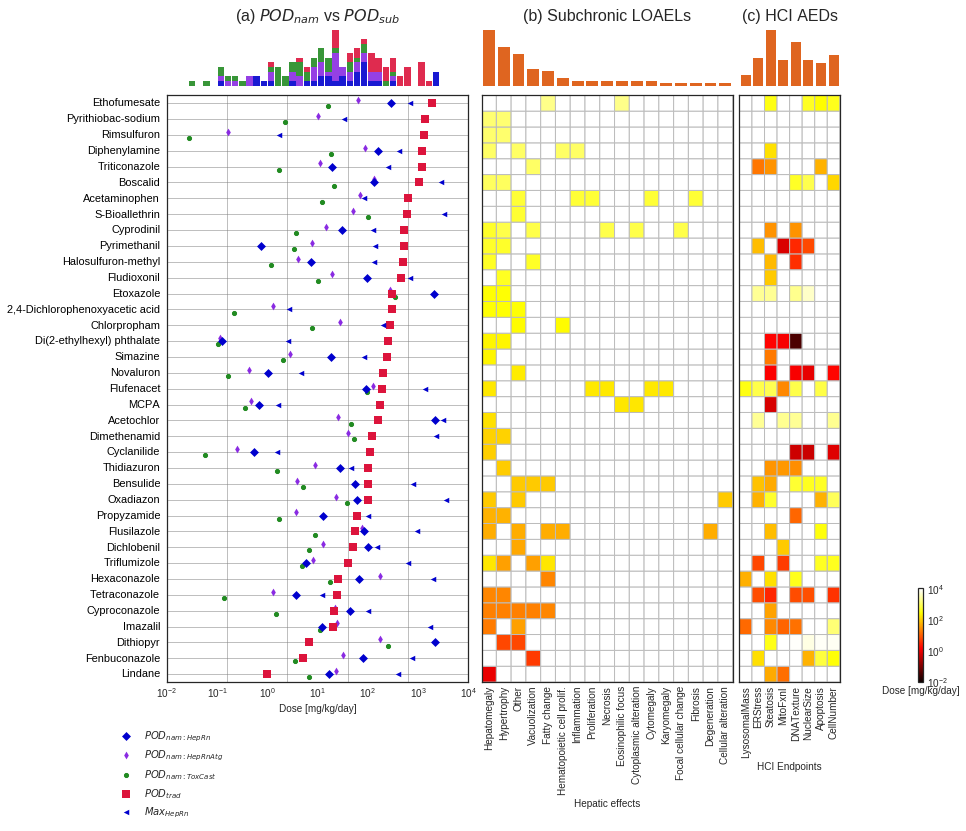

In [118]:
from viz.ivive import *
from viz.ivive import *
I = POD_nmtx.sort_values('loael_p05').index
drawIVIVE(LPR.loc[I],POD_nmtx.loc[I],POD_effect.loc[I],POD_hcift.loc[I],fill_hm=1e5,
          fig_text=sub_fig_txt,Podi=chr_pod_info,
          lpr_info=chr_lpr_info,
          cmap=cmap_b,
          pod_range=ddict(xmin=1e-2,xmax=1e4,num=6),
          fig_sz=[15,13],
          fig_file=FIG_DIR+'figure-8-sub-tcpl-qc.svg')

## Figure 8: Chronic

In [51]:
Q = {'$and':[{'$or':[dict(assay='HepRn'),
                    dict(assay='HepRnAtg'),
                    dict(assay='ToxCast',platform='All')
                   ]},
             dict(study_type='CHR',
                  potency_meth='tcpl:ac50:manual_qc',
                  #potency_meth='tcpl:ac50',
                  dose_metric='cmax',
                  ivive_method='time-averaged',
                  potency_name='ac50_p05',
                  pod_name='loael_p05')
            ]}

X = pd.DataFrame(HCI.potency_aed_pod.find(Q,dict(_id=0)))

In [52]:
X.insert(X.shape[1],'LPR',np.log10(X.pod_value/X.aed))
X1 = X[(X.ft=='All') & (X.effect=='All')]

In [53]:
Feats = pd.DataFrame(list(HCI.hci_feats.find(dict(),dict(_id=0))))
FT2NM = dict(zip(Feats.FA1,Feats.FN1))

LPR    = X1.pivot_table(index=['name','dsstox_sid'],
                      columns='assay',
                      values='LPR',
                      aggfunc=_p05).sort_values('HepRn',ascending=False)

# Remove the following two lines for the full data
#LPR  = LPR[LPR.HepRn.notnull()]
#LPR  = LPR.iloc[[i for i in range(0,LPR.shape[0],2)]]


POD_nam= X1.pivot_table(index=['name','dsstox_sid'],
                      columns='assay',
                      values='aed',
                      aggfunc=_p05).loc[LPR.index]
POD_tox= X1.pivot_table(index=['name','dsstox_sid'],
                      columns='pod_name',
                      values='pod_value',
                      aggfunc=_p05)
POD_nmtx = POD_nam.merge(POD_tox,left_index=True,right_index=True).loc[LPR.index]

POD_effect=X[X.effect!='All'].pivot_table(index=['name','dsstox_sid'],
                      columns='effect',
                      values='pod_value',
                      aggfunc=_p05).loc[LPR.index]
C = POD_effect.notnull().sum().sort_values(ascending=False).index
POD_effect = POD_effect[C]
POD_hcift = X[X.ft!='All'].pivot_table(index=['name','dsstox_sid'],
                      columns='ft',
                      values='aed',
                      aggfunc=_p05)\
                .rename(columns=FT2NM)
Y = POD_nmtx.merge(POD_hcift,left_index=True,right_index=True,how='left')
POD_hcift = Y[POD_hcift.columns].loc[POD_nmtx.index]
#C = POD_hcift.notnull().sum().sort_values(ascending=False).index
C = [FT2NM[i] for i in C1]
POD_hcift = POD_hcift[C]

#POD_hcift = POD_hcift.loc[LPR.index.intersection(POD_hcift.index)]

In [54]:
POD_tox.head()

,pod_name,loael_p05
name,dsstox_sid,
"2,4-Dichlorophenoxyacetic acid",DTXSID0020442,143.52
Acetochlor,DTXSID8023848,50.00
Alachlor,DTXSID1022265,14.00
Ametryn,DTXSID1023869,145.30
Bensulide,DTXSID9032329,60.00


Include the max dose tested into the data POD_nmtx

In [56]:
from heprnhci.tk.httk import *
Res=[]
for (chm,dtxsid) in POD_nmtx.index:
    casrn = HCI.chemicals.find_one(dict(name=chm))['casrn']
    print(chm,dtxsid,casrn)
    y=calcAED(casrn,'Rat',days_ivt=1,days_ivv=730,dose_ivt=100,
            dose_metric='cmax',
            method='time-averaged',
            dbc_iviv=HCI.heprn_iviv_max)
    Res.append(dict(name=chm,dsstox_sid=dtxsid,heprn_max_conc=y))
Max_conc=pd.DataFrame(Res).set_index(['name','dsstox_sid'])

Di(2-ethylhexyl) phthalate DTXSID5020607 117-81-7
Novaluron DTXSID5034773 116714-46-6
Pyrimethanil DTXSID8034877 53112-28-0
Propamocarb hydrochloride DTXSID6034849 25606-41-1
Tetraconazole DTXSID8034956 112281-77-3
Fenarimol DTXSID2032390 60168-88-9
Isoxaflutole DTXSID5034723 141112-29-0
Diuron DTXSID0020446 330-54-1
Triticonazole DTXSID0032655 131983-72-7
Propyzamide DTXSID2020420 23950-58-5
Carbaryl DTXSID9020247 63-25-2
Simazine DTXSID4021268 122-34-9
Triadimefon DTXSID3023897 43121-43-3
Thidiazuron DTXSID0032651 51707-55-2
Ethofumesate DTXSID8034580 26225-79-6
Imazalil DTXSID8024151 35554-44-0
Ametryn DTXSID1023869 834-12-8
Diphenylamine DTXSID4021975 122-39-4
Dichlobenil DTXSID5032365 1194-65-6
Boscalid DTXSID6034392 188425-85-6
Fludioxonil DTXSID2032398 131341-86-1
Cyprodinil DTXSID1032359 121552-61-2
Lindane DTXSID2020686 58-89-9
Zoxamide DTXSID9032581 156052-68-5
Fenbuconazole DTXSID8032548 114369-43-6
Bensulide DTXSID9032329 741-58-2
Resmethrin DTXSID7022253 10453-86-8
Flufena

In [57]:
POD_nmtx = POD_nmtx.merge(Max_conc,left_index=True,right_index=True)

#### Figure properties

In [58]:
from heprnhci.viz.ivive import *
from copy import deepcopy


chr_fig_txt = ddict(a=ddict(title=r'(a) $POD_{nam}$ vs $POD_{trad}$',
                            xlab='Dose [mg/kg/day]',
                            lg_bb=(-0.2,-0.25)),
                     b=ddict(title=r'(b) $LPR_5$',
                             xlab='LPR'),
                     c=ddict(title=r'(b) Chronic $LOAEL_5$',
                             xlab='Hepatic effects'),
                     d=ddict(title=r'(c) HCI $AED_5$',
                             xlab='HCI Endpoints')
                            )

chr_pod_info=ddict(HepRn=ddict(color='mediumblue',
                                     marker='D',
                                     dy=0,z=30,size=40,lw=0.8,
                                     label='$POD_{nam:HepRn}$'),
                    HepRnAtg=ddict(color='blueviolet',
                                   marker='d',
                                   dy=0.2,z=8,size=30,lw=0.5,
                                   label='$POD_{nam:HepRnAtg}$'),
                    ToxCast=ddict(color='forestgreen',
                             marker='8',
                             dy=-0.2,z=5,size=30,lw=0.4,
                             label='$POD_{nam:ToxCast}$'),
                    loael_p05=ddict(color='crimson',
                             marker='s',
                             dy=0,z=15,size=50,lw=0.5,
                             label='$POD_{trad}$'),
#                    heprn_max_conc=ddict(color='mediumblue',
#                                      marker='<',
#                                      dy=0,z=25,size=30,lw=0.8,
#                                      label='$Max_{HepRn}$')
                  )

chr_lpr_info = ddict(HepRn=ddict(color='mediumblue',
                                     label='$LPR_{HepRn}$'),
                    HepRnAtg=ddict(color='blueviolet',
                                   label='$LPR_{HepRnAtg}$'),
                    ToxCast=ddict(color='forestgreen',
                             label='$LPR_{ToxCast}$')
                    )
             
cmap_a = ddict(tox=cm.hot,hts=cm.Blues_r,lpr=cm.RdYlBu_r)
cmap_b = ddict(tox=cm.hot,hts=cm.hot,lpr=cm.RdYlBu_r)

### Save the integrated data

In [59]:
CHR_ALL = LPR.rename(columns={i:'LPR_'+i for i in LPR.columns})\
              .merge(POD_nmtx.rename(columns={i:'AED_'+i for i in POD_nmtx.columns}),left_index=True,right_index=True)\
              .merge(POD_effect.rename(columns={i:'POD_'+i for i in POD_effect.columns}),left_index=True,right_index=True)\
              .merge(POD_hcift.rename(columns={i:'AED_'+i for i in POD_hcift.columns}),left_index=True,right_index=True)
#CHR_ALL.to_excel(SUP_DIR+'chr-all.xlsx')

#### Draw

In [60]:
POD_nmtx.head()

,,HepRn,HepRnAtg,ToxCast,loael_p05,heprn_max_conc
name,dsstox_sid,,,,,
Di(2-ethylhexyl) phthalate,DTXSID5020607,0.02,0.01,0.01,600.0,0.32
Novaluron,DTXSID5034773,0.44,0.18,0.07,884.2,1.97
Pyrimethanil,DTXSID8034877,0.75,7.91,3.43,221.0,138.16
Propamocarb hydrochloride,DTXSID6034849,8.77,8.82,0.55,682.0,37.79
Tetraconazole,DTXSID8034956,3.64,1.32,0.14,59.0,12.27


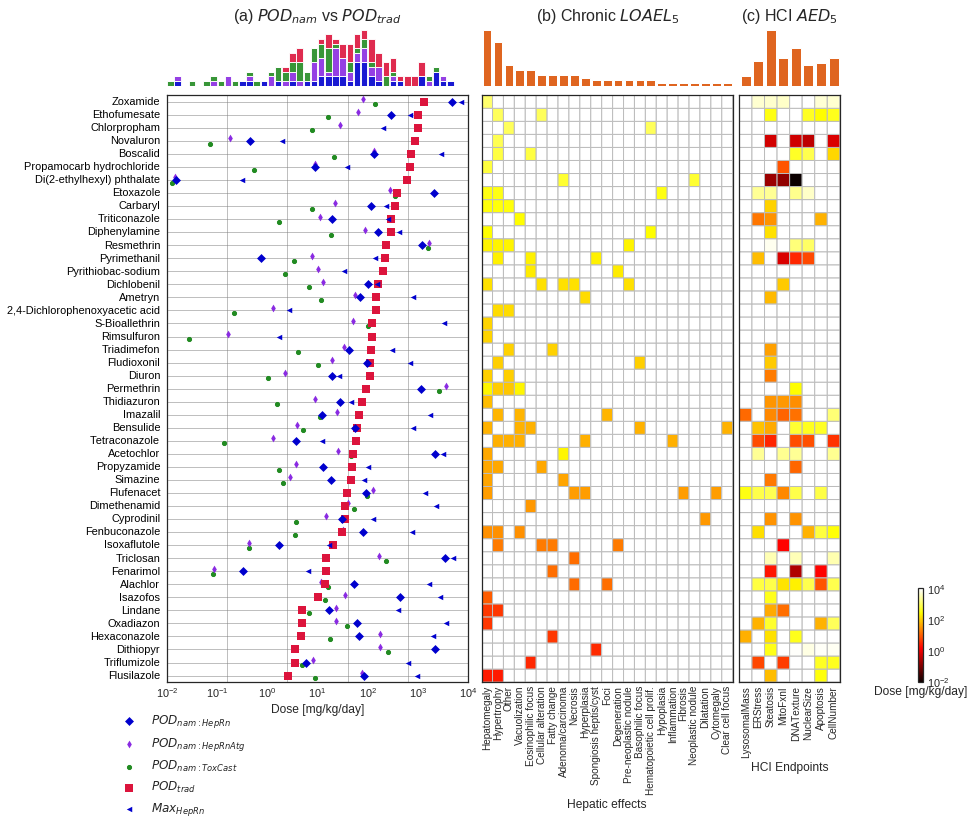

In [61]:
from heprnhci.viz.ivive import *
I = POD_nmtx.sort_values('loael_p05').index
drawIVIVE(LPR.loc[I],POD_nmtx.loc[I],POD_effect.loc[I],POD_hcift.loc[I],fill_hm=1e5,
          fig_text=chr_fig_txt,Podi=chr_pod_info,
          lpr_info=chr_lpr_info,
          cmap=cmap_b,
          pod_range=ddict(xmin=1e-2,xmax=1e4,num=6),
          fig_sz=[15,13],
          fig_file=FIG_DIR+'figure-8-chr-tcpl-qc.svg')

Prose: Run the SUB and CHR then the following

In [247]:
X0 = LPR.loc[LPR.HepRn.isnull()]
I0 = LPR.loc[LPR.HepRn.isnull()]
X1 = POD_effect.loc[I0.index]\
        .apply(lambda x: ', '.join(POD_effect.columns.str.lower()[x.notnull()]),axis=1)\
                .reset_index().rename(columns={0:'effect'})\
               .sort_values('effect')
# ', '.join(map(lambda x: x.lower(), 
#                ["%(name)s (%(effect)s)" % i for i in X1.loc[X0.index].to_dict('records') ]))
X1

,name,dsstox_sid,effect
3,Dimethenamid,DTXSID4032376,"hepatomegaly, hypertrophy"
4,Pyrithiobac-sodium,DTXSID8032673,"hepatomegaly, hypertrophy"
5,Rimsulfuron,DTXSID1032642,"hepatomegaly, hypertrophy"
0,"2,4-Dichlorophenoxyacetic acid",DTXSID0020442,"hepatomegaly, hypertrophy, other"
6,S-Bioallethrin,DTXSID2039336,other
2,Chlorpropham,DTXSID7020764,"other, hematopoietic cell prolif."
1,Acetaminophen,DTXSID2020006,"other, inflammation, proliferation, cytomegaly, fibrosis"


In [248]:
X0 = LPR.loc[LPR.HepRn.isnull()]
X1 = POD_tox.loc[X0.index]
print("No HepRn hits",X0.shape[0],X0.shape[0]/LPR.shape[0]*1.)
X0

No HepRn hits 7 0.1891891891891892


,assay,HepRn,HepRnAtg,ToxCast
name,dsstox_sid,,,
"2,4-Dichlorophenoxyacetic acid",DTXSID0020442,NaN,2.37,3.14
Acetaminophen,DTXSID2020006,NaN,0.95,1.70
Chlorpropham,DTXSID7020764,NaN,0.99,1.56
Dimethenamid,DTXSID4032376,NaN,0.46,0.36
Pyrithiobac-sodium,DTXSID8032673,NaN,2.13,2.78
Rimsulfuron,DTXSID1032642,NaN,3.90,4.69
S-Bioallethrin,DTXSID2039336,NaN,1.07,0.78


In [236]:
Res = []
X0 = LPR.loc[LPR.HepRn.isnull()]
X1 = POD_tox.loc[X0.index]
for c in X0.reset_index().name:
    y=calcAED(c,'Rat',days_ivt=1,days_ivv=90,dose_ivt=100,
            dose_metric='cmax',
            method='time-averaged',
            dbc_iviv=HCI.heprn_iviv)
    Res.append(y)#dict(name=c,max_aed=y))
X1.insert(X1.shape[1],'max_aed',Res)

X0

,assay,HepRn,HepRnAtg,ToxCast
name,dsstox_sid,,,
"2,4-Dichlorophenoxyacetic acid",DTXSID0020442,NaN,2.05,2.82
Chlorpropham,DTXSID7020764,NaN,1.55,2.12
Dimethenamid,DTXSID4032376,NaN,-0.06,-0.16
Pyrithiobac-sodium,DTXSID8032673,NaN,1.29,1.94
Rimsulfuron,DTXSID1032642,NaN,2.86,3.65
S-Bioallethrin,DTXSID2039336,NaN,0.38,0.09


In [235]:
X1.loc[X1.max_aed>X1.loael_p05]

,pod_name,loael_p05,max_aed
name,dsstox_sid,,
Dimethenamid,DTXSID4032376,36.0,1000.0
S-Bioallethrin,DTXSID2039336,122.6,1000.0


In [249]:
X0 = LPR.loc[LPR.HepRn.isnull()]
X1 = POD_tox.loc[X0.index]
X1

,pod_name,loael_p05
name,dsstox_sid,
"2,4-Dichlorophenoxyacetic acid",DTXSID0020442,300.0
Acetaminophen,DTXSID2020006,625.0
Chlorpropham,DTXSID7020764,276.0
Dimethenamid,DTXSID4032376,119.0
Pyrithiobac-sodium,DTXSID8032673,1376.0
Rimsulfuron,DTXSID1032642,1311.0
S-Bioallethrin,DTXSID2039336,593.8


In [250]:
I0 = LPR.loc[LPR.HepRn<-1]
X0 = POD_effect.loc[I0.index].min(axis=1).reset_index().rename(columns={0:'POD'})\
               .sort_values('POD')
', '.join(map(lambda x: x.lower(), 
              ["%(name)s (%(POD).2f mg/kg/day)" % i for i in X0.to_dict('records') ]))

'lindane (1.00 mg/kg/day), fenbuconazole (5.10 mg/kg/day), dithiopyr (6.62 mg/kg/day), hexaconazole (25.00 mg/kg/day), oxadiazon (100.00 mg/kg/day), acetochlor (161.10 mg/kg/day), etoxazole (300.40 mg/kg/day)'

In [100]:
I0 = LPR.loc[LPR.HepRn<-1]
X1 = POD_effect.loc[I0.index]\
        .apply(lambda x: ', '.join(POD_effect.columns.str.lower()[x.notnull()]),axis=1)\
                .reset_index().rename(columns={0:'effect'})\
               .sort_values('effect')
', '.join(map(lambda x: x.lower(), 
               ["%(name)s (%(effect)s)" % i for i in X1.loc[X0.index].to_dict('records') ]))


'flusilazole (hepatomegaly, hypertrophy), triflumizole (eosinophilic focus), dithiopyr (spongiosis heptis/cyst), hexaconazole (fatty change), oxadiazon (hepatomegaly), isazofos (hepatomegaly), alachlor (necrosis, foci), triclosan (necrosis), flufenacet (hepatomegaly, necrosis, hyperplasia, fibrosis, cytomegaly), acetochlor (hepatomegaly, adenoma/carcinoma), permethrin (hepatomegaly, hypertrophy, other, vacuolization), etoxazole (hepatomegaly, hypertrophy, hypoplasia)'

In [115]:
FT2W=dict(zip(['Apoptosis', 'CellNumber', 'DNATexture', 'ERStress', 'LysosomalMass',
               'MitoFxnI', 'NuclearSize', 'Steatosis'],
              ['apoptosis', 'cell number', 'DNA texture', 'ER stress', 'lysosomal mass',
               'mitochondrial function', 'nuclear size', 'steatosis']))
              
    
I0 = LPR.loc[LPR.HepRn<-1]
Hc2= POD_hcift.rename(columns=FT2W)
X2 = Hc2.loc[I0.index]\
        .apply(lambda x: ', '.join(Hc2.columns.str.lower()[x==x.min()]),axis=1)\
                .reset_index().rename(columns={0:'hci'})
X2 = X2.merge(POD_hcift.loc[I0.index].min(axis=1)\
                .reset_index().rename(columns={0:'aed'}),
              on=['name','dsstox_sid'])

', '.join(map(lambda x: x.lower(), 
               ["%(name)s (%(hci)s %(aed)i mg/kg/day)" % i for i in X2.loc[X0.index].to_dict('records') ]))


'flusilazole (steatosis 76 mg/kg/day), triflumizole (mitochondrial function 5 mg/kg/day), dithiopyr (steatosis 404 mg/kg/day), hexaconazole (lysosomal mass 57 mg/kg/day), oxadiazon (apoptosis 62 mg/kg/day), isazofos (steatosis 429 mg/kg/day), alachlor (apoptosis 8 mg/kg/day), triclosan (cell number 3384 mg/kg/day), flufenacet (mitochondrial function 25 mg/kg/day), acetochlor (mitochondrial function 2142 mg/kg/day), permethrin (dna texture 289 mg/kg/day), etoxazole (dna texture 2078 mg/kg/day)'

In [122]:
(I0.ToxCast<-1).sum()
(I0.ToxCast<0).sum(),(I0.HepRnAtg<0).sum(),

(10, 10)

In [251]:
x=(LPR.HepRn.abs()<1).sum()
'HepRn',x,LPR.shape[0],x/LPR.shape[0],

('HepRn', 14, 37, 0.3783783783783784)

In [253]:
', '.join(LPR.loc[LPR.HepRn.abs()<1].reset_index().name.str.lower())

'triflumizole, bensulide, flufenacet, flusilazole, cyproconazole, dichlobenil, imazalil, boscalid, thidiazuron, tetraconazole, ethofumesate, propyzamide, fludioxonil, diphenylamine'

In [256]:
X0 = LPR.loc[LPR.HepRn.abs()<1]
x=(X0.ToxCast.abs()<1).sum()
y=(X0.ToxCast.abs()>1).sum()
'ToxCast',x,x/X0.shape[0], y,y/X0.shape[0]

('ToxCast', 5, 0.35714285714285715, 9, 0.6428571428571429)

In [258]:
(X0.ToxCast.abs()<1).sum()

5

In [134]:
X0 = LPR.loc[LPR.HepRn.abs()<1]
x=(X0.HepRnAtg.abs()<1).sum()
y=(X0.HepRnAtg.abs()>1).sum()
'HepRnAtg',x,x/X0.shape[0], y,y/X0.shape[0]

('HepRnAtg', 10, 0.43478260869565216, 13, 0.5652173913043478)

In [259]:
I0 = LPR.loc[LPR.HepRn>1]
X1 = POD_effect.loc[I0.index].min(axis=1).reset_index().rename(columns={0:'POD'})\
               .sort_values('POD')
X1 = X1.merge(POD_effect.loc[I0.index]\
              .apply(lambda x: ', '.join(POD_effect.columns.str.lower()[x.notnull()]),axis=1)\
              .reset_index().rename(columns={0:'effect'})\
              .sort_values('effect'),
             on=['name','dsstox_sid'])\
        .sort_values('POD')

print("LPR>1",X1.shape[0],X1.shape[0]/LPR.shape[0]*1.0)
', '.join(map(lambda x: x.lower(), 
               ["%(name)s (%(effect)s %(POD)i mg/kg/day)" % i for i in X1.to_dict('records') ]))



LPR>1 9 0.24324324324324326


'cyclanilide (hepatomegaly 113 mg/kg/day), mcpa (eosinophilic focus, cytoplasmic alteration 177 mg/kg/day), novaluron (other 197 mg/kg/day), simazine (hepatomegaly 247 mg/kg/day), di(2-ethylhexyl) phthalate (hepatomegaly, hypertrophy 250 mg/kg/day), halosulfuron-methyl (hepatomegaly, vacuolization 497 mg/kg/day), pyrimethanil (hepatomegaly, hypertrophy 529 mg/kg/day), cyprodinil (hepatomegaly, hypertrophy, vacuolization, necrosis, cytoplasmic alteration, focal cellular change 536 mg/kg/day), triticonazole (vacuolization 1183 mg/kg/day)'

In [261]:
FT2W=dict(zip(['Apoptosis', 'CellNumber', 'DNATexture', 'ERStress', 'LysosomalMass',
               'MitoFxnI', 'NuclearSize', 'Steatosis'],
              ['apoptosis', 'cell number', 'DNA texture', 'ER stress', 'lysosomal mass',
               'mitochondrial function', 'nuclear size', 'steatosis']))
              
    
I0 = LPR.loc[LPR.HepRn>1]
Hc2= POD_hcift.rename(columns=FT2W)
X2 = Hc2.loc[I0.index]\
        .apply(lambda x: ', '.join(Hc2.columns.str.lower()[x==x.min()]),axis=1)\
                .reset_index().rename(columns={0:'hci'})
X2 = X2.merge(POD_hcift.loc[I0.index].min(axis=1)\
                .reset_index().rename(columns={0:'aed'}),
              on=['name','dsstox_sid'])\
        .sort_values('aed')

', '.join(map(lambda x: x.lower(), 
               ["%(name)s (%(hci)s %(aed).2f mg/kg/day)" % i for i in X2.to_dict('records') ]))


'di(2-ethylhexyl) phthalate (dna texture 0.04 mg/kg/day), cyclanilide (nuclear size 0.54 mg/kg/day), mcpa (steatosis 0.69 mg/kg/day), pyrimethanil (mitochondrial function 0.75 mg/kg/day), novaluron (nuclear size 0.97 mg/kg/day), halosulfuron-methyl (dna texture 4.19 mg/kg/day), triticonazole (er stress 17.85 mg/kg/day), simazine (steatosis 18.11 mg/kg/day), cyprodinil (dna texture 31.11 mg/kg/day)'

In [147]:
X0 = LPR.loc[LPR.HepRn>1]
x=(X0.ToxCast>1).sum()
y=(X0.ToxCast>1).sum()
'ToxCast',x,x/X0.shape[0], y,y/X0.shape[0]

('ToxCast', 4, 1.0, 4, 1.0)

In [149]:
X0 = LPR.loc[LPR.HepRn>1]
x=(X0.HepRnAtg>1).sum()
y=(X0.HepRnAtg>1).sum()
'HepRnAtg',x,x/X0.shape[0], y,y/X0.shape[0]

('HepRnAtg', 4, 1.0, 4, 1.0)

In [154]:
X0 = LPR.loc[LPR.HepRn>1]
10**np.mean(X0.ToxCast-X0.HepRn)

7.422620773643917

# Key findings stated in the manuscript

The following sections show how all of the key findings (e.g. the numbers of chemicals, their effects, potency values, ADEs etc). were calculated 

## Methods

### Rat hepatotoxicity data, PODs and chemical selection

In [48]:
# HCI.toxref_rat_v2.count()
# HCI.toxref_rat_v2.find_one()#dict(loael=dict({'$exists':1})))

In [49]:
Chr = HCI.potency_aed_pod.find(dict(study_type='CHR')).distinct('name')
Sub = HCI.potency_aed_pod.find(dict(study_type='SUB')).distinct('name')

In [54]:
print("CHR=%i, SUB=%i CHR & SUB = %i" % (len(Chr),len(Sub),len(set(Chr).intersection(Sub))))

CHR=45, SUB=37 CHR & SUB = 32


## Results

### High content imaging

#### Hits by end points and timeh

In [100]:
Q  = dict(assay={'$in':['HepRn']},
          platform='APR:HepRn:Tm:Ft',
          #ft={'$nin':['All']},
          potency_name='ac50_p05',
          potency_meth='tcpl:ac50:manual_qc')
F  = dict(_id=0)
H1 = pd.DataFrame(HCI.potency.find(Q,F))

H1.pivot_table(index=['assay','platform','timeh'],
               columns='ft',
               values = 'dsstox_sid',
               aggfunc = lambda x: len(set(x)))[C1]

ft                           LM  ES  St  MF  DT  NS  Ap  CN
assay platform        timeh                                
HepRn APR:HepRn:Tm:Ft 24      1   8  17   5  12   5   9   4
                      48      3   3  15  10   7   6   2  10
                      72      1   7  17   9  15   9   5  15

#### Summary Hits by time

In [102]:
Q  = dict(assay={'$in':['HepRn']},
          platform='APR:HepRn:Tm',
          #ft={'$nin':['All']},
          potency_name='ac50_p50',
          potency_meth='tcpl:ac50:manual_qc')
F  = dict(_id=0)
H2 = pd.DataFrame(HCI.potency.find(Q,F))

H2.pivot_table(index=['assay','platform','timeh'],
               columns='ft',
               values = 'dsstox_sid',
               aggfunc = lambda x: len(set(x)))

ft                        All
assay platform     timeh     
HepRn APR:HepRn:Tm 24      29
                   48      29
                   72      34

#### Summarise hits by assay features

In [112]:
Q  = dict(assay={'$in':['HepRn']},
          platform='APR:HepRn:Tm:Ft',
          #ft={'$nin':['All']},
          #potency_name='ac50_p50',
          potency_meth='tcpl:ac50:manual_qc')
F  = dict(_id=0)
H2 = pd.DataFrame(HCI.potency.find(Q,F))

H2.pivot_table(index=['assay','platform'],
               columns='ft',
               values = 'dsstox_sid',
               aggfunc = lambda x: len(set(x)))[C1]

,ft,LM,ES,St,MF,DT,NS,Ap,CN
assay,platform,,,,,,,,
HepRn,APR:HepRn:Tm:Ft,5,13,33,15,22,12,12,16


The distribution of concentration-responsive effects of chemicals on an endpoint (i.e. hits) are summarized in Figure 1. Across all time points, 43/51 chemicals produced at least one hit. There were 29/51, 29/51 and 34/51 chemicals that produced hits at 24, 48 and 72 h, respectively (Table 1). Endpoint-wise, 33, 22, 16, 15, 13, 12, 12 and 5 chemicals produced hits for steatosis, DNA texture, cell number, mitochondrial function, ER stress, apoptosis, nuclear size and lysosomal mass, respectively. Although 8/51 chemicals (2,4-dichlorophenoxyacetic acid, acetaminophen, bentazone, chlorpropham, dimethenamid, pyrithiobac-sodium, rimsulfuron and S-bioallethrin) produced changes in some of the endpoints at certain concentrations and time points, they did not produce concentration-dependent effects based on our criteria for assigning hits (see Methods). The remainder of this analysis focuses on the 43/51 chemicals that produced at least one hit. 

In [121]:
Q  = dict(assay={'$in':['HepRn']},
          platform='APR:HepRn:Tm:Ft',
          ft={'$nin':['All']},
          potency_name='ac50_p50',
          potency_meth='tcpl:ac50:manual_qc')
F  = dict(_id=0)
H3 = pd.DataFrame(HCI.potency.find(Q,F))

H3.pivot_table(index=['assay','platform'],
               columns='timeh',
               values = 'potency_val',
               aggfunc = _p05)

,timeh,24,48,72
assay,platform,,,
HepRn,APR:HepRn:Tm:Ft,1.73,1.01,1.63


In [128]:
X = H3.groupby(['assay','platform','ft'])\
  .aggregate(dict(potency_val=[_p05,_p50]))
X.columns=[i+j for (i,j) in X.columns]
X.sort_values('potency_val_p05')

potency_val_p05  potency_val_p50
assay platform        ft                                  
HepRn APR:HepRn:Tm:Ft MF             0.64            24.64
                      LM             1.21            27.80
                      DT             1.30            34.79
                      Ap             1.43            46.68
                      ES             1.63            45.14
                      NS             5.04            38.10
                      St             6.00            32.07
                      CN            30.24            68.82

In [129]:
X.sort_values('potency_val_p50')

potency_val_p05  potency_val_p50
assay platform        ft                                  
HepRn APR:HepRn:Tm:Ft MF             0.64            24.64
                      LM             1.21            27.80
                      St             6.00            32.07
                      DT             1.30            34.79
                      NS             5.04            38.10
                      ES             1.63            45.14
                      Ap             1.43            46.68
                      CN            30.24            68.82

The distribution of AC50 values across all chemicals and endpoints for each time point are summarized in Figure 2 (and provided in Supplemental Table S2). The 5th percentile of AC50 values across all chemicals were 1.73, 1.01 and 1.63 µM at 24, 48 and 72 h, respectively. Endpoint-wise, the 5th percentile of potency values (in ascending) order were 0.64, 1.21, 1.3, 1.43, 1.63, 5.04, 6.0 and 30.24 µM for mitochondrial function, lysosomal mass, DNA texture, apoptosis, ER stress, nuclear size, steatosis and cell number, respectively. Mitochondrial function and lysosomal mass were also the most sensitive endpoints across time based on median AC50 values. The median potency values for all endpoints across time points were 24.64, 27.8, 32.07, 34.79, 38.1, 45.14, 46.68 and 68.82 µM for mitochondrial function, lysosomal mass, steatosis, DNA texture, nuclear size, ER stress, apoptosis and cell number, respectively. We used the 5th percentile of AC50 values for each chemical at a given time point as the critical concentration for IVIVE analysis.


### Comparing HepRn Potency values with ToxCast

In [185]:
# Data
HepRnTm = pd.DataFrame(HCI.potency.find(dict(assay='HepRn',platform='APR:HepRn:Tm'),dict(_id=0)))
ToxCast = pd.DataFrame(HCI.potency.find(dict(assay='ToxCast',platform='All'),dict(_id=0)))

HepRnTx = HepRnTm.merge(ToxCast,on=['dsstox_sid','name','potency_name','potency_meth','ft'],how='left')\
                 .replace(dict(potency_name=dict(ac50_p05=r'$AC50_{p5}$',
                                                  ac50_p50=r'$AC50_{p50}$',
                                                  ac50_p95=r'$AC50_{p95}$')))


RES=[]
Ci = ['potency_name','timeh_x','platform_y']
for Fi,Xi in HepRnTx[HepRnTx.potency_meth=='tcpl:ac50:manual_qc'].groupby(Ci):
    R = dict(zip(Ci,Fi))
    R.update({k:f(Xi['potency_val_x'],Xi['potency_val_y']) for k,f in Summary_F.items()})
    RES.append(R)

X_cmp = pd.DataFrame(RES)


In [186]:
X_cmp.pivot_table(index=['potency_name'],
                  columns='timeh_x',
                  values='R_p')

timeh_x,24,48,72
potency_name,,,
$AC50_{p50}$,1.04e-03,-0.25,0.25
$AC50_{p5}$,1.43e-01,0.44,0.38
$AC50_{p95}$,-2.77e-01,-0.10,-0.05


In [187]:
X_cmp.pivot_table(index=['potency_name'],
                  columns='timeh_x',
                  values='p_p')

timeh_x,24,48,72
potency_name,,,
$AC50_{p50}$,1.00,0.20,0.16
$AC50_{p5}$,0.46,0.02,0.03
$AC50_{p95}$,0.15,0.59,0.77


We compared of the AC50 values for all chemicals obtained using the rat primary hepatocyte HCI assays with ToxCast assays in three ways. First, we calculated the Pearson correlation (ρ) and the coefficient of determination (R2) for the 5th, 50th (median) and 95th percentiles of AC50 values (denoted as, AC505, AC5050, and AC5095, respectively) for the 43 chemicals between the HepRn assay and the ToxCast assays for all three durations of in vitro exposure and the results are summarized visually in Figure 3. There were some weak associations between the AC505 values from HepRn and ToxCast at 48 h (ρ=0.44 (p-value=0.02)) and at 72 h (ρ=0.38 (p-value=0.03)). Second, we compared the AC505, AC5050, and AC5095 at each time point of the HepRn assay and each assay technology in the ToxCast assay technology types. The correlation scores and number of chemicals (that produced a hit) between the HepRn assays and the different ToxCast technology types are shown in Figure 4. For the AC505 values, a maximum Pearson correlation score of ρ=0.32 was observed between the ToxCast BSK assay and the HepRn72h assays based on 34 chemicals, and the ToxCast BSK AC505 values were 5 times lower than the AC505 values from the HepRn72h. The next highest correlation score of ρ=0.32 was observed between the ToxCast CLD and the HepRn48h assays based on 23 chemicals (AC505 values from ToxCast were on average 13-fold lower than HepRn48h). All remaining correlations were either weaker or did not include enough chemicals to be significant. 

### Summary of in vivo hepatic effects and LOAELs

In [243]:
EF0 = pd.DataFrame(HCI.rat_pod_v2.find(dict(),dict(_id=0)))
def _n(x): return len(set(x))
    
X0 =EF0[EF0.effect!='All']\
    .groupby(['effect','study_type'])\
    .aggregate(dict(pod_value=[_p05,_p50,_p95],
                    name=_n))
X0.columns = [i+j for i,j in X0.columns]
X0.insert(0,'POD',["%(pod_value_p50)i (%(pod_value_p05)i,%(pod_value_p95)i)"%j for j in X0.to_dict('records')])

X0a = EF0[EF0.effect=='All']\
    .groupby(['effect','study_type'])\
    .aggregate(dict(pod_value=[_p05,_p50,_p95],
                    name=_n))
X0a.columns = [i+j for i,j in X0a.columns]
X0a.insert(0,'POD',["%(pod_value_p50)i (%(pod_value_p05)i,%(pod_value_p95)i)"%j for j in X0a.to_dict('records')])

X1 =X0.pivot_table(index='effect',
                   columns=['study_type'],
                   values='POD',aggfunc=lambda x: x[0])
X2 = X0.pivot_table(index='effect',
                   columns=['study_type'],
                   values='name_n').rename(columns=dict(CHR='Chr_n',SUB='Sub_n'))
X3 = X1.merge(X2,on='effect')
X3.insert(0,'N',X3[['Chr_n','Sub_n']].max(axis=1))
X3.sort_values('N',ascending=False,inplace=True)
X3 = X3.drop('N',axis=1)[['SUB','Sub_n','CHR','Chr_n']]
X3.loc['All']=[X0a.loc[('All','SUB'),'POD'],
                     X0a.loc[('All','SUB'),'name_n'],
                     X0a.loc[('All','CHR'),'POD'],
                     X0a.loc[('All','CHR'),'name_n']]
X3.insert(2,'Sub_p',np.round(100*X3.Sub_n/X3.loc['All','Sub_n'],decimals=0))
X3.insert(4,'Chr_p',np.round(100*X3.Chr_n/X3.loc['All','Chr_n'],decimals=0))

X3.to_excel(DAT_DIR+'table-3.xlsx')
X3

study_type,SUB,Sub_n,Sub_p,CHR,Chr_p,Chr_n
effect,,,,,,
Hepatomegaly,"219 (21,1311)",24.0,63.0,"93 (4,682)",49.0,22.0
Hypertrophy,"275 (11,1353)",16.0,42.0,"143 (3,943)",38.0,17.0
Other,"100 (6,1250)",13.0,34.0,"128 (59,1000)",18.0,8.0
Vacuolization,"100 (5,1183)",7.0,18.0,"62 (30,286)",13.0,6.0
Eosinophilic focus,"1038 (177,1900)",2.0,5.0,"130 (3,755)",13.0,6.0
Fatty change,"77 (24,1900)",6.0,16.0,"17 (4,114)",9.0,4.0
Necrosis,"497 (191,803)",2.0,5.0,"27 (14,162)",9.0,4.0
Adenoma/carcinoma,NaN,NaN,NaN,"206 (45,600)",9.0,4.0
Cellular alteration,"100 (100,100)",1.0,3.0,"105 (20,1003)",9.0,4.0


Get the most sensitive endpoints 

In [262]:
Sens=[]
for (st),Xi in X0.reset_index().groupby('study_type'):
    #print(st)
    Sens += Xi.sort_values('pod_value_p05').iloc[:2].to_dict('records')
pd.DataFrame(Sens)    

,effect,study_type,POD,pod_value_p05,pod_value_p50,pod_value_p95,name_n
0,Eosinophilic focus,CHR,"130 (3,755)",3.50,130.00,755.91,6
1,Spongiosis heptis/cyst,CHR,"112 (3,221)",3.63,112.31,221.00,2
2,Vacuolization,SUB,"100 (5,1183)",5.10,100.00,1183.50,7
3,Other,SUB,"100 (6,1250)",6.62,100.00,1250.54,13


MAD between the p5 and p50 for LOAELs 

In [276]:
EF0 = pd.DataFrame(HCI.rat_pod_v2.find(dict(),dict(_id=0)))
def _n(x): return len(set(x))
    
X0 =EF0[EF0.effect=='All']\
        .pivot_table(index=['name','study_type'],
                     columns='pod_name',
                     values='pod_value')

Res = []
for (st),Xi in X0.reset_index().groupby('study_type'):
    print(st,np.median(np.abs(Xi.loael_p50-Xi.loael_p05)))

CHR 0.0
SUB 0.0


A summary of the hepatic effects for the 51 chemicals in chronic and subchronic testing is given in Table 3. Liver weight changes (hepatomegaly) were the most frequent effects in both study types. For chronic studies, 49% (22/45) of the chemicals produced liver weight changes relative to body weight with a median LOAEL (LOAEL50) of 93 mg/kg/day while 33% (24/38) produced the same effect in subchronic studies with a LOAEL50 = 219 mg/kg/day. Liver hypertrophy was observed for 38% (17/45) and 42% (16/38) chemicals for chronic and subchronic studies with LOAEL50 values of 143 and 275 mg/kg/day, respectively. Other histopathological effects were observed for fewer than 10 chemicals. 

The lowest LOAEL50 across all effects observed in chronic and subchronic studies was observed for fatty change (17 mg/kg/day) and necrosis (27 mg/kg/day), respectively. 

Though hepatomegaly was the most predominant effect, eosinophilic foci and vacuolization were the most sensitive endpoints with lowest 5th percentile of LOAEL values (LOAEL5) for chronic (3.5 mg/kg/day) and subchronic studies (5.1 mg/kg/day). 

We defined the in vivo POD values (referred to as PODtox) for all 51 chemicals for subchronic and chronic studies using the LOAEL5 across all effect types (denoted as PODsub and PODchr, respectively). The aggregated data for PODsub and PODchr for all chemicals is included in Supplemental Table S1.

### Comparing POD values from NAMs and animal toxicity studies

In [134]:
Q = {'$and':[{'$or':[dict(assay='HepRn',platform='APR:HepRn:Tm'),
                    dict(assay='HepRnAtg'),
                    dict(assay='ToxCast',platform='All')
                   ]},
             dict(potency_meth='tcpl:ac50:manual_qc',
                  potency_name='ac50_p05',
                  effect='All',ft='All',
                  pod_name='loael_p05')
            ]}


PERF = pd.DataFrame(HCI.performance.find(Q,dict(_id=0)))
FX = ['study_type','assay','platform','ft','ivive_method',
      'potency_meth',u'dose_metric',
      'potency_name','pod_name','effect','days_ivt']
MT = list(PERF.columns.difference(FX))
F = dict(LPR=np.mean,PR=np.mean,RMSE=np.mean,n_chem=np.median,R2=np.mean,R_p=np.mean,LPR_lt_1=np.mean)
PERF_1 = PERF.groupby(['study_type','ivive_method','assay','dose_metric'])\
              .aggregate(F)
PERF_2 = PERF_1.reset_index()
PERF_2.sort_values('R_p',ascending=False).iloc[:5]

,study_type,ivive_method,assay,dose_metric,LPR,PR,RMSE,n_chem,R2,R_p,LPR_lt_1
3,CHR,css,HepRnAtg,q0.05,1.64,43.40,13.33,45,1.88e-03,0.20,0.30
4,CHR,css,HepRnAtg,q0.50,2.03,105.95,15.60,45,1.35e-04,0.19,0.22
0,CHR,css,HepRn,q0.05,1.01,10.27,8.43,27,7.38e-02,0.18,0.44
1,CHR,css,HepRn,q0.50,1.40,25.33,9.93,27,1.20e-02,0.18,0.41
2,CHR,css,HepRn,q0.95,2.19,154.39,13.89,27,9.37e-04,0.16,0.23


We used PBTK modeling to estimate the AEDs from the AC50 values for chemicals using HepRn and the ToxCast assays as described in Methods. We assumed that the AED corresponding to the AC505 are NAM-based POD predictions (PODnam) that we refer to as PODHepRn and PODToxCast for the HepRn and ToxCast assays, respectively. The comparison between the PODtox and PODnam for the two assays, three in vitro timepoints, two in vivo study types and multiple pharmacokinetic options are visualized as scatterplots in Figures 6 and 7 and summarized in Table 4. We used several metrics to compare the PODnam and PODtox values including: log10(PODtox/PODnam) POD ratio (LPR), coefficient of determination (R2), Spearman correlation (ρ), and the fraction of chemicals for which POD values were within 1 log unit (|LPR|≤1). Although the correlations for the chronic studies were generally greater than those for subchronic studies, no single approach produced PODnam values that were significantly associated with PODtox values for subchronic or chronic studies (maximum value of ρ = 0.2). 

#### Summarise LPR or PR

#### IVIVE methods 

In [117]:
PR_1 = PERF_1.reset_index()
#PR_1 = PR_1[PR_1.ivive_method!='css']
X1=PR_1.groupby(['ivive_method'])\
    .aggregate(dict(PR=[np.mean,np.std])).round(decimals=1)
X1

PR       
                     mean    std
ivive_method                    
css                 492.9  781.8
time-averaged        83.5  187.6
time-final-matched   83.5  187.5
time-matched          2.9    5.3

In [118]:
PR_1 = PERF_1.reset_index()
#PR_1 = PR_1[PR_1.ivive_method!='css']
X1=PR_1.groupby(['dose_metric'])\
    .aggregate(dict(PR=[np.mean,np.std])).round(decimals=1)
X1.columns=[i+'_'+j for i,j in X1.columns]
X1

,PR_mean,PR_std
dose_metric,,
auc,159.3,241.0
cave,1.2,1.3
cmax,9.5,10.4
q0.05,91.0,91.2
q0.50,212.7,207.4
q0.95,1175.0,1086.5


In [365]:
X1.reset_index().to_dict('records')

[{'PR_mean': 159.3, 'PR_std': 241.0, 'dose_metric': 'auc'},
 {'PR_mean': 1.2, 'PR_std': 1.3, 'dose_metric': 'cave'},
 {'PR_mean': 9.5, 'PR_std': 10.4, 'dose_metric': 'cmax'},
 {'PR_mean': 91.0, 'PR_std': 91.2, 'dose_metric': 'q0.05'},
 {'PR_mean': 212.7, 'PR_std': 207.4, 'dose_metric': 'q0.50'},
 {'PR_mean': 1175.0, 'PR_std': 1086.5, 'dose_metric': 'q0.95'}]

In [367]:
', '.join(["%(PR_mean).1f (SD %(PR_std).f) for %(dose_metric)s" %x for x in X1.reset_index().to_dict('records')])

'159.3 (SD 241) for auc, 1.2 (SD 1) for cave, 9.5 (SD 10) for cmax, 91.0 (SD 91) for q0.05, 212.7 (SD 207) for q0.50, 1175.0 (SD 1086) for q0.95'

##### Study-type: Chronic vs subchronic

In [119]:
PR_1 = PERF_1.reset_index()
PR_1 = PR_1[PR_1.ivive_method!='css']
X1=PR_1.groupby(['study_type','assay'])\
    .aggregate(dict(PR=[np.mean,np.std])).round(decimals=1)
X1.columns=[i+'_'+j for i,j in X1.columns]

X1

PR_mean  PR_std
study_type assay                    
CHR        HepRn         8.1    15.5
           HepRnAtg     48.2    91.6
           ToxCast     168.0   323.7
SUB        HepRn         4.1     6.3
           HepRnAtg     21.8    32.9
           ToxCast      89.8   149.5